## Evidence of non-$\Lambda$ cosmology from parameteric and nonparameteric reconstruction methods

In this notebook, we systematically explore the Gaussian process regression (GP) and parametric methods for the reconstruction of the dark energy density and the corresponding equation of state. We divide this into four parts: (1) the data set, (2) quadratic and cubic parametric methods, (3) GP, and (4) assessment of performance.

*Main references*:

(1) Victor H. Cardenas, *Exploring hints for dark energy density evolution in light of recent data*, **2015**, Phys. Lett. B 750, 128-134, [1405.5116 [astro-ph.CO]](https://arxiv.org/abs/1405.5116)

(2) Daniela Grandon and Victor H. Cardenas, *Studies on dark energy evolution*, **2021**, Class. Quantum Grav. 38 145008, [2107.04876 [astro-ph.CO]](https://arxiv.org/abs/2107.04876)

(3) Reginald Christian Bernardo and Jackson Levi Said, *A data-driven reconstruction of Horndeski gravity via the Gaussian processes*, **2021**, JCAP 09 (2021) 014, [2105.12970 [astro-ph.CO]](https://arxiv.org/abs/2105.12970)

(4) Reginald Christian Bernardo and Jackson Levi Said, *Towards a model-independent reconstruction approach for late-time Hubble data*, **2021**, JCAP 08 (2021) 027, [2106.08688 [[astro-ph.CO]](https://arxiv.org/abs/2106.08688)

*$*$References to the data sets can be found at the end of the notebook.*

In [1]:
from __future__ import division
import numpy as np
from numpy import loadtxt, savetxt
from scipy.constants import c
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # for the insets
from math import log10
import seaborn as sns

import corner
from numpy import *
from sys import *
import emcee
from scipy.optimize import minimize
from scipy import interpolate
from scipy.integrate import quad

from matplotlib.ticker import MaxNLocator
from scipy.interpolate import griddata
from numpy.linalg import multi_dot

from getdist import plots, MCSamples
import getdist
import pickle
import time
from multiprocessing import Pool

# for monte carlo error propagation
from scipy.linalg import block_diag
from numpy.random import multivariate_normal as MN
import scipy.stats as st

c_kms = c/1000 # speed of light in km/s

### 1. Hubble data

We consider the cosmic chronometers (CC) and baryon acoustic oscillations (BAO) compiled data set for the Hubble function $H(z)$ at various redshifts $z$ at late times. This is visualized below.

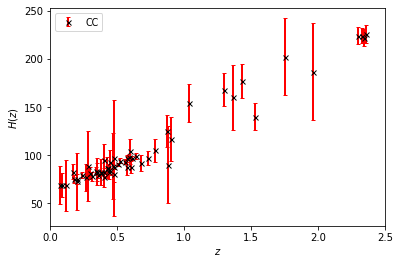

In [2]:
# load cc dataset
loc_cc = '../../datasets/Hdz_2020.txt'
#loc_cc = 'Hdz_2020.txt'
cc_data = loadtxt(loc_cc)

# setup cc observations
z_cc = cc_data[:, 0]
Hz_cc = cc_data[:, 1]
sigHz_cc = cc_data[:, 2]

plt.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, label = 'CC',
             fmt = 'kx', markersize = 5,
             ecolor = 'red', elinewidth = 2, capsize = 2)
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(0, 2.5)
plt.show()

The redshift distribution of this data set is shown in the next line.

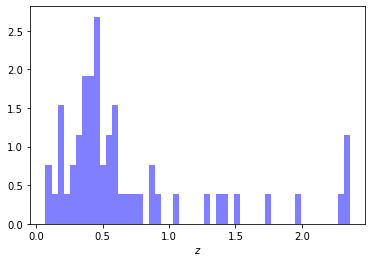

In [3]:
plt.hist(z_cc, bins = 50, color = 'b',
         alpha = 0.5, label = 'H(z)', density = True)
plt.xlabel('$z$')
plt.show()

The discussion of this notebook is then anchored to how well the parametric and nonparametric reconstruction methods fit this data. The normalized dark energy density $X(z)$ can easily be obtained from this:
\begin{equation}
X(z) = \dfrac{E(z)^2 - \Omega_m (1 + z)^3}{1 - \Omega_m} ,
\end{equation}
where $E(z) = H(z)/H_0$ is the normalized Hubble function and $\Omega_m$ is the density fraction of nonrelativistic matter, a.k.a. CDM and visible matter. We aso consider for the analysis three $H_0$ priors reflecting the Hubble tension.

In [4]:
# H0 values reflecting the Hubble tension
H0_priors = {'P18': {'ave': 67.4, 'std': 0.5},
             'TRGB': {'ave': 69.8, 'std': 1.9},
             'A21': {'ave': 71.5, 'std': 1.8},
             'R21': {'ave': 73.04, 'std': 1.04}}

om0_priors = {'P18': {'ave': 0.1430, 'std':0.0011}, #omegam h2
              'Pantheon': {'ave': 0.298, 'std': 0.022}}

### 2. Parametric DE reconstruction

In this section, we present the parametric reconstruction methods for dark energy. This comes as in the form of expansions about some redshift set by the size of the data. In particular, we shall consider both quadratic and cubic parametrizations of this type.

#### Quadratic parametrization

To start, we consider the quadratic parametrization of $X(z)$.

In [5]:
def Xz_qd(z, zm, f1, f2):
    '''returns the quadratic parameterized DE density'''
    return 1 + (z*(4*f1 - f2 - 3)/zm) - (2*(z**2)*(2*f1 - f2 - 1)/(zm**2))

def Xpz_qd(z, zm, f1, f2):
    '''returns the first derivative X'(z)'''
    return -((3 - 4*f1 + f2)/zm) + (4*(1 - 2*f1 + f2)*z/(zm**2))

def wz_qd(z, zm, f1, f2):
    '''returns the dark energy equation of state in the quadratic parameterization'''
    x1 = f1
    x2 = f2
    return (z + 1)*(-z*(8*x1 - 4*x2 - 4)/zm**2 + (4*x1 - x2 - 3)/zm) \
           /(-3*z**2*(4*x1 - 2*x2 - 2)/zm**2 + 3*z*(4*x1 - x2 - 3)/zm + 3) - 1

def Ez_qd(z, zm, om0, f1, f2): # cosmology E(z) = H(z)/H
    '''returns the rescaled Hubble function for quadratic parametric reconstruction'''
    z1 = 1 + z
    Xm = om0*(z1**3)
    Xz = Xz_qd(z, zm, f1, f2)
    Ol = (1 - om0)*Xz
    return sqrt(Xm + Ol)
    
def chi2_cc_qd(H0, om0, f1, f2, H0_prior, om0_prior, zm = 2.36):
    model = H0*Ez_qd(z_cc, zm, om0, f1, f2)
    inv_sigma2 = 1/(sigHz_cc**2)
    PRI = ((H0 - H0_prior['ave'])/H0_prior['std'])**2 + \
          ((om0*(H0/100)**2 - om0_prior['ave'])/om0_prior['std'])**2
    chi2 = np.sum(((Hz_cc - model)**2)*inv_sigma2) + PRI
    return chi2 + PRI

def loglike_cc_qd(H0, om0, f1, f2, H0_prior, om0_prior, zm = 2.36):
    return -0.5*chi2_cc_qd(H0, om0, f1, f2, H0_prior, om0_prior, zm)

We then perform a Markov chain Monte-Carlo (MCMC) to estimate the parameters of this model. We shall do so as well considering three $H_0$ priors reflecting the cosmological tension between early- and late-time data. This computation and the results are shown below.

In [6]:
best_fits_qd = {'P18': {'H0': 67.4, 'Om': 0.5, 'x1': 1, 'x2':1},
                'TRGB': {'H0': 67.4, 'Om': 0.5, 'x1':1 , 'x2':1},
                'A21': {'H0': 67.4, 'Om': 0.5, 'x1':1 , 'x2':1},
                'R21': {'H0': 67.4, 'Om': 0.5, 'x1': 1, 'x2':1}}

ndim, nwalkers = 4, 8
nburn = 100
nmcmc = 5000

#chimint_planck=lambda x: -lnprob_planck(x)
#chimint_shoes =lambda x: -lnprob_shoes(x)

dres = [0.03, 0.05, 0.03, 0.03]
burnin = 100
results_qd = []

samples_qd = {}

for H0_prior in H0_priors:
    def nloglike(x):
        '''params: H0, om0, f1, f2 = x[0], x[1], x[2], x[3]'''
        return loglike_cc_qd(x[0], x[1], x[2], x[3], H0_priors[H0_prior], om0_priors['P18'])
    def chimint(x):
        return -nloglike(x)
    
    print('searching the initial position ...')
    print(H0_prior)
    rest = minimize(chimint, [70, 0.3, 1, 1], method = 'Nelder-Mead')
    print('minimization 0.5*chi2', rest.x)
    result = rest.x
    with Pool() as pool:
        start=time.time()
        sampler = emcee.EnsembleSampler(nwalkers, ndim, nloglike, pool = pool)

        pos0 = [result + dres*np.random.randn(ndim) for i in range(nwalkers)]

        print("Running MCMC...")
        pos1 = sampler.run_mcmc(pos0, nburn, rstate0 = np.random.get_state())
        sampler.run_mcmc(pos1, nmcmc, rstate0 = np.random.get_state(), progress = True)
        print("Done.")

        samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        results_qd.append(samps)
        names = ["H0", "om0", "x1", "x2"]
        labels = ["H_0", "\Omega_{m0}", "x_1", "x_2"]

        samples_qd[H0_prior] = MCSamples(samples = samps, names = names, labels = labels)    

        H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
                          zip(*np.percentile(samps, [16, 50, 84], \
                                           axis=0)))
        print("""MCMC result:
            $H_0$ = {0[0]} + {0[1]} - {0[2]} 
            $\Omega_m0$      = {1[0]} + {1[1]} - {1[2]}
            $x_1$    = {2[0]} + {2[1]} - {2[2]}
            $x_2$    = {3[0]} + {3[1]} - {3[2]}
        """.format(H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc))
        
        best_fits_qd[H0_prior]['H0'] = H0_mcmc
        best_fits_qd[H0_prior]['Om'] = om0_mcmc
        best_fits_qd[H0_prior]['x1'] = x1_mcmc
        best_fits_qd[H0_prior]['x2'] = x2_mcmc
        
        print("Mean acceptance fraction:",
              np.mean(sampler.acceptance_fraction), time.time() - start)

searching the initial position ...
P18
minimization 0.5*chi2 [67.36772253  0.31506398  0.76406824 -0.57693227]
Running MCMC...


100%|██████████| 5000/5000 [00:39<00:00, 125.24it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 67.33272156392134 + 0.35502692397703584 - 0.3409769331985615 
            $\Omega_m0$      = 0.31539889494277384 + 0.0037739343095479216 - 0.00367663168366017
            $x_1$    = 0.774477041257882 + 0.12898933754113873 - 0.12431351590143846
            $x_2$    = -0.5269036200636592 + 0.6295315489908169 - 0.6317065302612999
        
Mean acceptance fraction: 0.5918872549019607 40.714922189712524
searching the initial position ...
TRGB
minimization 0.5*chi2 [69.04301494  0.29995463  0.67159004 -0.47142532]
Running MCMC...


100%|██████████| 5000/5000 [00:39<00:00, 126.68it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 68.91828506661334 + 1.202818640939185 - 1.286180068922306 
            $\Omega_m0$      = 0.30101109343007537 + 0.011828626385318175 - 0.010282059457778825
            $x_1$    = 0.6788258077203108 + 0.1351010522313273 - 0.12964217037286707
            $x_2$    = -0.4946518559467587 + 0.5818617854711908 - 0.600202428893921
        
Mean acceptance fraction: 0.5889215686274509 40.41083860397339
searching the initial position ...
A21
minimization 0.5*chi2 [70.57039384  0.28710656  0.59617389 -0.38531283]
Running MCMC...


100%|██████████| 5000/5000 [00:39<00:00, 126.76it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 70.45541855851462 + 1.2193712937436203 - 1.2339653896302707 
            $\Omega_m0$      = 0.28808115174143006 + 0.010590924932492363 - 0.009869052760736186
            $x_1$    = 0.6051635850235542 + 0.12804047744140945 - 0.12261047646643786
            $x_2$    = -0.3686305180313035 + 0.56737204751778 - 0.5687950169930718
        
Mean acceptance fraction: 0.5864460784313725 40.27372097969055
searching the initial position ...
R21
minimization 0.5*chi2 [72.61221258  0.2711809   0.5065901  -0.28293585]
Running MCMC...


100%|██████████| 5000/5000 [00:39<00:00, 126.48it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 72.52746978264483 + 0.7143627216914155 - 0.7240539052774579 
            $\Omega_m0$      = 0.2718272597208099 + 0.005693548977355634 - 0.005470706086640353
            $x_1$    = 0.5128616153524964 + 0.10910231065456322 - 0.10386441716362882
            $x_2$    = -0.28012340620850057 + 0.5086858080486363 - 0.4937385294734595
        
Mean acceptance fraction: 0.5893382352941177 40.331685304641724


The posteriors for the quadratic parametrized DE is shown below.

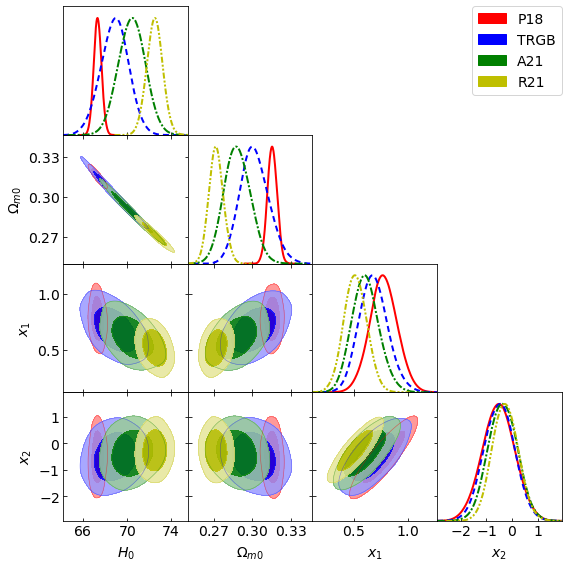

In [7]:
g = plots.getSubplotPlotter()
g.settings.axes_labelsize = 17
g.settings.axes_fontsize = 17
g.settings.legend_fontsize = 17
g.triangle_plot([samples_qd['P18'], samples_qd['TRGB'], samples_qd['A21'], samples_qd['R21']], filled = True,
                legend_labels = ['P18', 'TRGB', 'A21', 'R21'], contour_colors = ['r', 'b', 'g', 'y'],
                contour_ls = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))], contour_lws = 2, legend_loc = 'upper right')

The reconstructed DE densities are calculated in the next line.

In [8]:
def reconstruct_DE_qd(H0_prior, z_rec, zm = 2.36, n_s = 1000):
    '''quadratic parametrized reconstruction of X(z) and w(z) given an H0 prior
    errors: propagated using MC'''
    
    mean = np.array([np.mean(samples_qd[H0_prior][0]),
                     np.mean(samples_qd[H0_prior][1]),
                     np.mean(samples_qd[H0_prior][2]),
                     np.mean(samples_qd[H0_prior][3])])
    stdm = np.array([np.std(samples_qd[H0_prior][0]),
                     np.std(samples_qd[H0_prior][1]),
                     np.std(samples_qd[H0_prior][2]),
                     np.std(samples_qd[H0_prior][3])])
    covm = samples_qd[H0_prior].cov()
    covt = covm
    
    Xz_curves = []
    Xpz_curves = []
    wz_curves = []
    awz_curves = []
    
    for j in np.arange(0, n_s): # jth random draw
        Hz_j, om0_j, x1_j, x2_j = MN(mean, covt)
        Xz_j = Xz_qd(z_rec, zm, x1_j, x2_j)
        Xpz_j = Xpz_qd(z_rec, zm, x1_j, x2_j)
        wz_j = wz_qd(z_rec, zm, x1_j, x2_j)
        
        Xz_curves.append(Xz_j)
        Xpz_curves.append(Xpz_j)
        wz_curves.append(wz_j)
        awz_curves.append(np.arctan(1 + wz_j))
        
    Xz_curves = np.array(Xz_curves)
    Xpz_curves = np.array(Xpz_curves)
    wz_curves = np.array(wz_curves)
    awz_curves = np.array(awz_curves)
        
    Xz = np.zeros((len(z_rec), 2))
    Xpz = np.zeros((len(z_rec), 2))
    wz = np.zeros((len(z_rec), 2))
    awz = np.zeros((len(z_rec), 7))
    
    # sample redshifts to get DE EoS posterior
    awz_z_samps = []
    i_samps = [int(len(z_rec)*x) for x in np.linspace(0, 1, 5)]
    if len(z_rec) in i_samps:
        len_z_index = i_samps.index(len(z_rec))
        i_samps[len_z_index] = len(z_rec) - 1
    
    for i in np.arange(0, len(z_rec)):
        Xz[i][0] = np.mean(Xz_curves[:, i])
        Xz[i][1] = np.std(Xz_curves[:, i])
        Xpz[i][0] = np.mean(Xpz_curves[:, i])
        Xpz[i][1] = np.std(Xpz_curves[:, i])
        wz[i][0] = np.mean(wz_curves[:, i])
        wz[i][1] = np.std(wz_curves[:, i])

        awz[i][0] = np.mean(awz_curves[:, i])
        awz[i][1] = np.std(awz_curves[:, i])
        awz[i][2] = st.skew(awz_curves[:, i]) 
        awz[i][3] = st.kurtosis(awz_curves[:, i], fisher = True)
        awz[i][4] = np.percentile(awz_curves[:, i], 50) # median of awz
        awz[i][5] = np.percentile(awz_curves[:, i], 50 - 34.1)
        awz[i][6] = np.percentile(awz_curves[:, i], 50 + 34.1)
        
        if i in i_samps:
            awz_z_samps.append([z_rec[i], awz_curves[:, i]])
        
    return z_rec, Xz, Xpz, wz, awz, awz_z_samps

# reconstruct per prior, store in dictionary DE_qd
DE_qd = {}
z_min = 0
z_max = 2.5
n_div = 100
z_rec = np.linspace(z_min, z_max, n_div)
n_s = 20000
for H0_prior in H0_priors:
    z, Xz, Xpz, wz, awz, awz_z_samps = reconstruct_DE_qd(H0_prior, z_rec, zm = 2.36, n_s = n_s)
    DE_qd[H0_prior] = {'z': z, 'Xz': Xz, 'Xpz': Xpz, 'wz': wz,
                       'awz': awz, 'awz_samps': awz_z_samps}

So, for the quadratic parametrization, we obtain the $X(z)$ posteriors below.

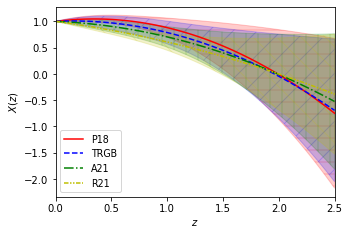

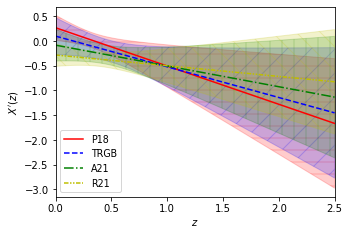

In [9]:
fig, ax = plt.subplots(figsize = (5, 3.5))

clr = ['r', 'b', 'g', 'y']
lst = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))]
htc = ['-', '/', '|', '\\']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_qd[H0_prior]['z']
    Xz = DE_qd[H0_prior]['Xz'][:, 0]
    sigXz = DE_qd[H0_prior]['Xz'][:, 1]
    
    # plot X(z) reconstruction
    ax.plot(z, Xz, color = clr[i], linestyle = lst[i], label = H0_prior)
    ax.fill_between(z, Xz - 2*sigXz,
                    Xz + 2*sigXz,
                    alpha = .2, facecolor = clr[i],
                    edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

# plot X'(z) statistic
fig, ax = plt.subplots(figsize = (5, 3.5))
for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_qd[H0_prior]['z']
    Xpz = DE_qd[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_qd[H0_prior]['Xpz'][:, 1]
    
    # plot X(z) reconstruction
    ax.plot(z, Xpz, color = clr[i], linestyle = lst[i], label = H0_prior)
    ax.fill_between(z, Xpz - 2*sigXpz,
                    Xpz + 2*sigXpz,
                    alpha = .2, facecolor = clr[i],
                    edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X^\prime(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

Here are the plots.

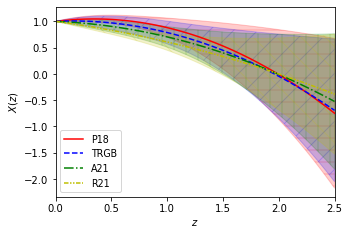

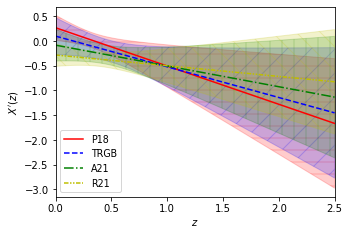

In [10]:
fig, ax = plt.subplots(figsize = (5, 3.5))

clr = ['r', 'b', 'g', 'y']
lst = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))]
htc = ['-', '/', '|', '\\']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_qd[H0_prior]['z']
    Xz = DE_qd[H0_prior]['Xz'][:, 0]
    sigXz = DE_qd[H0_prior]['Xz'][:, 1]
    
    # plot X(z) reconstruction
    ax.plot(z, Xz, color = clr[i], linestyle = lst[i], label = H0_prior)
    ax.fill_between(z, Xz - 2*sigXz,
                    Xz + 2*sigXz,
                    alpha = .2, facecolor = clr[i],
                    edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

# plot X'(z) statistic
fig, ax = plt.subplots(figsize = (5, 3.5))
for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_qd[H0_prior]['z']
    Xpz = DE_qd[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_qd[H0_prior]['Xpz'][:, 1]
    
    # plot X(z) reconstruction
    ax.plot(z, Xpz, color = clr[i], linestyle = lst[i], label = H0_prior)
    ax.fill_between(z, Xpz - 2*sigXpz,
                    Xpz + 2*sigXpz,
                    alpha = .2, facecolor = clr[i],
                    edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X^\prime(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

On the other hand, the dark energy equation of state posteriors and its compactified version are presented in the next line.

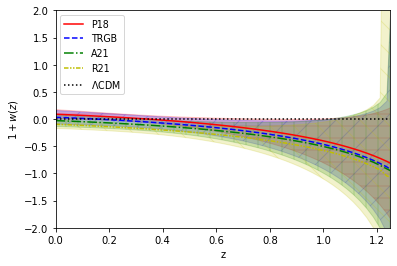

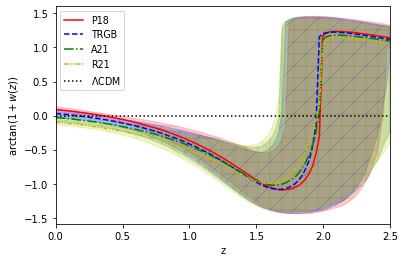

In [11]:
def plot_w_qd(H0_prior, ls, fc, hatch):
    
    z = DE_qd[H0_prior]['z']
    wz = DE_qd[H0_prior]['wz']
    
    plt.plot(z, 1 + wz[:, 0], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z,
                     1 + wz[:, 0] - 2*wz[:, 1],
                     1 + wz[:, 0] + 2*wz[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_aw_qd(H0_prior, ls, fc, hatch):
    
    z = DE_qd[H0_prior]['z']
    awz = DE_qd[H0_prior]['awz']
    
    plt.plot(z, awz[:, 4], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z, awz[:, 5], awz[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

# DE EoS
fig = plt.figure()
plot_w_qd('P18', ls = '-', fc = 'r', hatch = '-')
plot_w_qd('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_w_qd('A21', ls = '-.', fc = 'g', hatch = '|')
plot_w_qd('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('$1 + w(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max*0.5)
plt.ylim(-2, 2)
plt.show()

# compactified DE EoS
fig = plt.figure()
plot_aw_qd('P18', ls = '-', fc = 'r', hatch = '-')
plot_aw_qd('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_aw_qd('A21', ls = '-.', fc = 'g', hatch = '|')
plot_aw_qd('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('arctan($1 + w(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

It is also instructive to look at the posteriors of the compactified dark energy equation of state at sample redshifts.

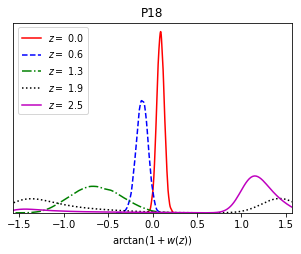

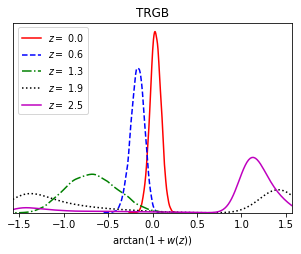

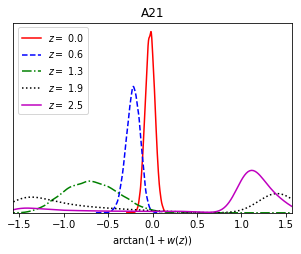

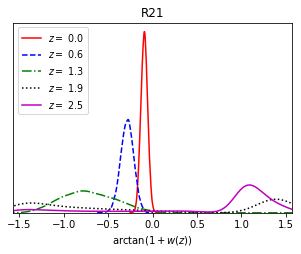

In [12]:
for H0_prior in H0_priors:
    
    awz_samps = DE_qd[H0_prior]['awz_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(awz_samps)):
        z_i = np.round(awz_samps[i][0], 1)
        sns.kdeplot(awz_samps[i][1], color = cl_list[i],
                    linestyle = ls_list[i],
                    ax = ax, common_norm = True,
                    label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
        
    plt.show()

We now move on to the cubic parametrization. We setup the code below to determine the Hubble function prediction and the likelihood with the data.

#### Cubic parametrization

The equations for $X(z)$, $w(z)$, and the likelihoods with respect to the data for the cubic parameterization are coded in the next line.

In [13]:
def Xz_cb(z, zm, f1, f2, f3):
    '''returns the cubic parametrized DE density'''
    Xz = ((9*(-1 + 3*f1 - 3*f2 + f3)*(z**3)) - (9*(-2 + 5*f1 - 4*f2 + f3)*zm*(z**2)) 
          + ((-11 + 18*f1 - 9*f2 + 2*f3)*z*(zm**2)) + (2*zm**3))/(2*(zm**3))
    return Xz

def Xpz_cb(z, zm, f1, f2, f3):
    '''returns the statistic X'(z) for dynamical dark energy'''
    term_1 = (-11 + 18*f1 - 9*f2 + 2*f3)/(2*zm)
    term_2 = -9*(-2 + 5*f1 - 4*f2 + f3)*z/(zm**2)
    term_3 = 27*(-1 + 3*f1 - 3*f2 + f3)*(z**2)/(2*(zm**3))
    return term_1 + term_2 + term_3

def wz_cb(z, zm, f1, f2, f3):
    '''returns the DE EoS in cubic parametrized DE'''
    x1 = f1
    x2 = f2
    x3 = f3
    num = z**2*(81*x1 - 81*x2 + 27*x3 - 27.0)/zm**3 \
          - z*(90*x1 - 72*x2 + 18*x3 - 36.0)/zm**2 \
          + (18*x1 - 9*x2 + 2*x3 - 11.0)/zm
    den = z**3*(27*x1 - 27*x2 + 9*x3 - 9.0)/zm**3 \
          - z**2*(45*x1 - 36*x2 + 9*x3 - 18.0)/zm**2 \
          + z*(18*x1 - 9*x2 + 2*x3 - 11.0)/zm
    return -1 + ((1/6)*(1 + z)*num)/(1 + (den/2))

def Ez_cb(z, zm, om0, f1, f2, f3):
    '''returns the Hubble function in cubic parameterized DE method'''
    z1 = 1 + z
    Xm = om0*(z1**3)
    Xz = Xz_cb(z, zm, f1, f2, f3)
    Ol = (1 - om0)*Xz
    return sqrt(Xm + Ol)

def chi2_cc_cb(H0, om0, f1, f2, f3, H0_prior, om0_prior, zm = 2.36):
    model = H0*Ez_cb(z_cc, zm, om0, f1, f2, f3)
    inv_sigma2 = 1/(sigHz_cc**2)
    PRI = ((H0 - H0_prior['ave'])/H0_prior['std'])**2 + \
          ((om0*(H0/100)**2 - om0_prior['ave'])/om0_prior['std'])**2
    chi2 = np.sum(((Hz_cc - model)**2)*inv_sigma2) + PRI
    return chi2 + PRI

def loglike_cc_cb(H0, om0, f1, f2, f3, H0_prior, om0_prior, zm = 2.36):
    return -0.5*chi2_cc_cb(H0, om0, f1, f2, f3, H0_prior, om0_prior, zm)

The sampling for the parameters is performed in the next line.

In [15]:
ndim, nwalkers = 5, 12
nburn = 100
nmcmc = 6000

dres = [0.03, 0.05, 0.03, 0.03, 0.03]
burnin = 100
results_cb = []

samples_cb = {}

best_fits_cb = {'P18': {'H0': 67.4, 'Om': 0.5, 'x1': 1, 'x2':1, 'x3':1},
                'TRGB': {'H0': 67.4, 'Om': 0.5, 'x1':1 , 'x2':1, 'x3':1},
                'A21': {'H0': 67.4, 'Om': 0.5, 'x1':1 , 'x2':1, 'x3':1},
                'R21': {'H0': 67.4, 'Om': 0.5, 'x1': 1, 'x2':1, 'x3':1}}

for H0_prior in H0_priors:    
    def nloglike(x):
        '''params: H0, om0, f1, f2, f3 = x[0], x[1], x[2], x[3], x[4]'''
        return loglike_cc_cb(x[0], x[1], x[2], x[3], x[4],
                             H0_priors[H0_prior], om0_priors['P18'])
    def chimint(x):
        return -nloglike(x)
    
    print('searching the initial position ...')
    print(H0_prior)
    rest = minimize(chimint, [70, 0.3, 1, 1, 1], method = 'Nelder-Mead')
    print('minimization 0.5*chi2', rest.x)
    result = rest.x
    with Pool() as pool:
        start=time.time()
        sampler = emcee.EnsembleSampler(nwalkers, ndim, nloglike, pool = pool)

        pos0 = [result + dres*np.random.randn(ndim) for i in range(nwalkers)]

        print("Running MCMC...")
        pos1 = sampler.run_mcmc(pos0, nburn, rstate0 = np.random.get_state())
        sampler.run_mcmc(pos1, nmcmc, rstate0 = np.random.get_state(), progress = True)
        print("Done.")

        samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        results_cb.append(samps)
        names = ["H0", "om0", "x1", "x2", "x3"]
        labels = ["H_0", "\Omega_{m0}", "x_1", "x_2", "x_3"]

        samples_cb[H0_prior] = MCSamples(samples = samps, names = names, labels = labels)    

        H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc, x3_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
                          zip(*np.percentile(samps, [16, 50, 84], \
                                           axis=0)))
        print("""MCMC result:
            $H_0$ = {0[0]} + {0[1]} - {0[2]} 
            $\Omega_m0$      = {1[0]} + {1[1]} - {1[2]}
            $x_1$    = {2[0]} + {2[1]} - {2[2]}
            $x_2$    = {3[0]} + {3[1]} - {3[2]}
            $X_3$    = {4[0]} + {4[1]} - {4[2]}
        """.format(H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc, x3_mcmc))

        best_fits_cb[H0_prior]['H0'] = H0_mcmc
        best_fits_cb[H0_prior]['Om'] = om0_mcmc
        best_fits_cb[H0_prior]['x1'] = x1_mcmc
        best_fits_cb[H0_prior]['x2'] = x2_mcmc
        best_fits_cb[H0_prior]['x3'] = x3_mcmc
        
        print("Mean acceptance fraction:",
              np.mean(sampler.acceptance_fraction), time.time() - start)

searching the initial position ...
P18
minimization 0.5*chi2 [67.42761868  0.31452872  1.16855538  1.11982475 -1.00312188]
Running MCMC...


100%|██████████| 6000/6000 [01:03<00:00, 94.11it/s] 


Done.
Removed no burn in
MCMC result:
            $H_0$ = 67.39971270554095 + 0.37137987839692244 - 0.3595153779370861 
            $\Omega_m0$      = 0.3147074659772543 + 0.0037640325736691405 - 0.0038015810806000805
            $x_1$    = 1.173033506245344 + 0.12401854341783602 - 0.12157752316517056
            $x_2$    = 1.1248354868058827 + 0.43288838208770564 - 0.40617922864025124
            $X_3$    = -0.9893238952919982 + 0.673647667093394 - 0.6358091356354315
        
Mean acceptance fraction: 0.5506693989071038 64.84192252159119
searching the initial position ...
TRGB
minimization 0.5*chi2 [70.08085991  0.29116368  1.0709322   1.18272126 -0.93651901]
Running MCMC...


100%|██████████| 6000/6000 [00:51<00:00, 116.93it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 69.88525029213773 + 1.2312346416080828 - 1.3541574835018508 
            $\Omega_m0$      = 0.2929018760604333 + 0.011758757965467326 - 0.01018660642313296
            $x_1$    = 1.0820205850644407 + 0.12152031632533733 - 0.11898283205202997
            $x_2$    = 1.2005197714315232 + 0.3903852292023313 - 0.41415870745712013
            $X_3$    = -0.9443445297014583 + 0.6129687932421994 - 0.610465908500905
        
Mean acceptance fraction: 0.5471857923497269 52.13379096984863
searching the initial position ...
A21
minimization 0.5*chi2 [71.68331194  0.27829144  1.01987469  1.21565879 -0.90135124]
Running MCMC...


100%|██████████| 6000/6000 [00:52<00:00, 114.37it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 71.41247574054097 + 1.2426814004142557 - 1.2325310277645514 
            $\Omega_m0$      = 0.2802699195843706 + 0.010145420148293283 - 0.009375376371664912
            $x_1$    = 1.0282389648133603 + 0.1146355450478751 - 0.1077165443760687
            $x_2$    = 1.2161644448228246 + 0.35555281539068684 - 0.35781294162608934
            $X_3$    = -0.9087899405270249 + 0.5504508080854595 - 0.5498532250208575
        
Mean acceptance fraction: 0.546844262295082 53.33513140678406
searching the initial position ...
R21
minimization 0.5*chi2 [73.08010114  0.26775518  0.97944892  1.24182289 -0.87334938]
Running MCMC...


100%|██████████| 6000/6000 [00:59<00:00, 100.20it/s]

Done.
Removed no burn in
MCMC result:
            $H_0$ = 73.00750500505666 + 0.7334373357974187 - 0.7365209170641975 
            $\Omega_m0$      = 0.2683704434202043 + 0.005650727923038834 - 0.00553517890314964
            $x_1$    = 0.9845965470219209 + 0.10155036003191253 - 0.10032339808883717
            $x_2$    = 1.2598684412394558 + 0.3486034573687955 - 0.3480913560389637
            $X_3$    = -0.8732218557336766 + 0.5269300950548461 - 0.5114457511957973
        
Mean acceptance fraction: 0.5492622950819672 61.19040393829346


Here are the posteriors for the cubic parameterized DE model.

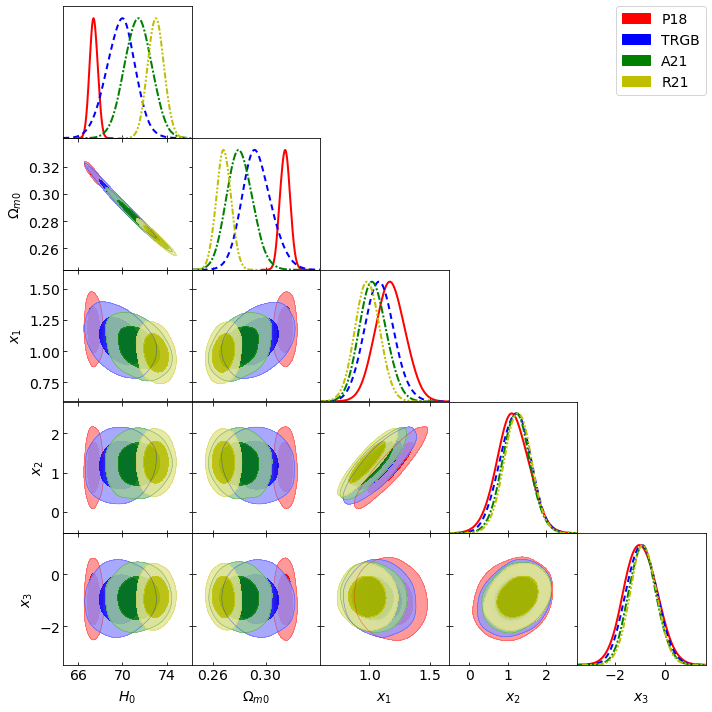

In [16]:
g = plots.getSubplotPlotter()
g.settings.axes_labelsize = 17
g.settings.axes_fontsize = 17
g.settings.legend_fontsize = 17
g.triangle_plot([samples_cb['P18'], samples_cb['TRGB'], samples_cb['A21'], samples_cb['R21']], filled = True,
                legend_labels = ['P18', 'TRGB', 'A21', 'R21'], contour_colors = ['r', 'b', 'g', 'y'],
                contour_ls = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))], contour_lws = 2, legend_loc = 'upper right')

Now, here are the posteriors of the DE and the DE EoS with their errors (propagated via a Monte Carlo routine).

In [17]:
def reconstruct_DE_cb(H0_prior, z_rec, zm = 2.36, n_s = 1000):
    '''quadratic parametrized reconstruction of X(z) and w(z) given an H0 prior
    errors: propagated using MC'''
    
    mean = np.array([np.mean(samples_cb[H0_prior][0]),
                     np.mean(samples_cb[H0_prior][1]),
                     np.mean(samples_cb[H0_prior][2]),
                     np.mean(samples_cb[H0_prior][3]),
                     np.mean(samples_cb[H0_prior][4])])
    stdm = np.array([np.std(samples_cb[H0_prior][0]),
                     np.std(samples_cb[H0_prior][1]),
                     np.std(samples_cb[H0_prior][2]),
                     np.std(samples_cb[H0_prior][3]),
                     np.std(samples_cb[H0_prior][4])])
    covm = samples_cb[H0_prior].cov()
    covt = covm # + np.diag(stdm**2) # total covariance
    
    Xz_curves = []
    Xpz_curves = []
    wz_curves = []
    awz_curves = []
    
    for j in np.arange(0, n_s): # jth random draw
        Hz_j, om0_j, x1_j, x2_j, x3_j = MN(mean, covt)
        Xz_j = Xz_cb(z_rec, zm, x1_j, x2_j, x3_j)
        Xpz_j = Xpz_cb(z_rec, zm, x1_j, x2_j, x3_j)
        wz_j = wz_cb(z_rec, zm, x1_j, x2_j, x3_j)
        
        Xz_curves.append(Xz_j)
        Xpz_curves.append(Xpz_j)
        wz_curves.append(wz_j)
        awz_curves.append(np.arctan(1 + wz_j))
        
    Xz_curves = np.array(Xz_curves)
    Xpz_curves = np.array(Xpz_curves)
    wz_curves = np.array(wz_curves)
    awz_curves = np.array(awz_curves)
        
    Xz = np.zeros((len(z_rec), 2))
    Xpz = np.zeros((len(z_rec), 2))
    wz = np.zeros((len(z_rec), 2))
    awz = np.zeros((len(z_rec), 7))
    
    # sample redshifts to get DE EoS posterior
    awz_z_samps = []
    i_samps = [int(len(z_rec)*x) for x in np.linspace(0, 1, 5)]
    if len(z_rec) in i_samps:
        len_z_index = i_samps.index(len(z_rec))
        i_samps[len_z_index] = len(z_rec) - 1
    
    for i in np.arange(0, len(z_rec)):
        Xz[i][0] = np.mean(Xz_curves[:, i])
        Xz[i][1] = np.std(Xz_curves[:, i])
        Xpz[i][0] = np.mean(Xpz_curves[:, i])
        Xpz[i][1] = np.std(Xpz_curves[:, i])
        wz[i][0] = np.mean(wz_curves[:, i])
        wz[i][1] = np.std(wz_curves[:, i])

        awz[i][0] = np.mean(awz_curves[:, i])
        awz[i][1] = np.std(awz_curves[:, i])
        awz[i][2] = st.skew(awz_curves[:, i]) 
        awz[i][3] = st.kurtosis(awz_curves[:, i], fisher = True)
        awz[i][4] = np.percentile(awz_curves[:, i], 50) # median of awz
        awz[i][5] = np.percentile(awz_curves[:, i], 50 - 34.1)
        awz[i][6] = np.percentile(awz_curves[:, i], 50 + 34.1)
        
        if i in i_samps:
            awz_z_samps.append([z_rec[i], awz_curves[:, i]])
        
    return z_rec, Xz, Xpz, wz, awz, awz_z_samps

# reconstruct per prior, store in dictionary DE_cb
DE_cb = {}
z_min = 0
z_max = 2.5
n_div = 100
z_rec = np.linspace(z_min, z_max, n_div)
n_s = 20000
for H0_prior in H0_priors:
    z, Xz, Xpz, wz, awz, awz_z_samps = reconstruct_DE_cb(H0_prior, z_rec, zm = 2.36, n_s = n_s)
    DE_cb[H0_prior] = {'z': z, 'Xz': Xz, 'Xpz': Xpz, 'wz': wz,
                       'awz': awz, 'awz_samps': awz_z_samps}

The reconstructed dark energy density in cubic parameterization is shown below.

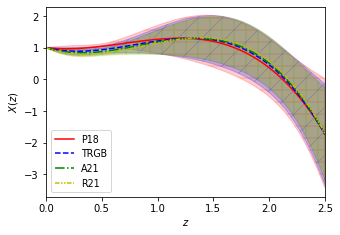

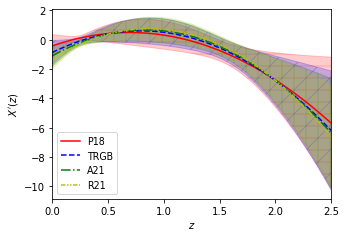

In [18]:
fig, ax = plt.subplots(figsize = (5, 3.5))

clr = ['r', 'b', 'g', 'y']
lst = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))]
htc = ['-', '/', '|', '\\']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_cb[H0_prior]['z']
    Xz = DE_cb[H0_prior]['Xz'][:, 0]
    sigXz = DE_cb[H0_prior]['Xz'][:, 1]
    
    # plot X(z) reconstruction
    plt.plot(z, Xz, color = clr[i], linestyle = lst[i], label = H0_prior)
    plt.fill_between(z, Xz - 2*sigXz,
                     Xz + 2*sigXz,
                     alpha = .2, facecolor = clr[i],
                     edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

# plot X'(z) statistic
fig, ax = plt.subplots(figsize = (5, 3.5))
for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_cb[H0_prior]['z']
    Xpz = DE_cb[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_cb[H0_prior]['Xpz'][:, 1]
    
    # plot X(z) reconstruction
    plt.plot(z, Xpz, color = clr[i], linestyle = lst[i], label = H0_prior)
    plt.fill_between(z, Xpz - 2*sigXpz, Xpz + 2*sigXpz,
                     alpha = .2, facecolor = clr[i],
                     edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X^\prime(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

Now, the dark energy equation of state, its compactified version, and its posteriors at sample redshifts are shown in the next line.

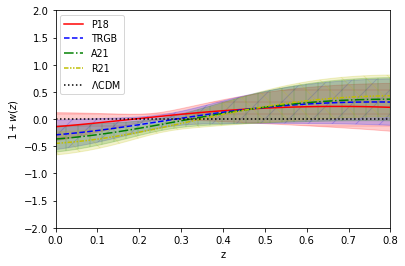

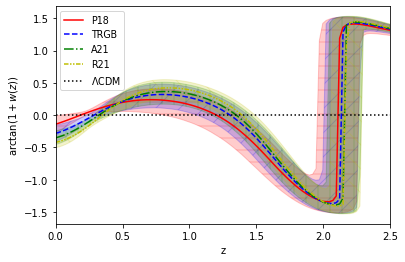

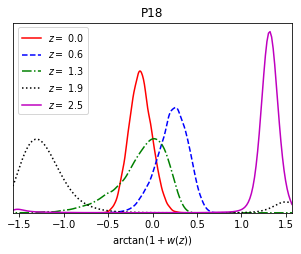

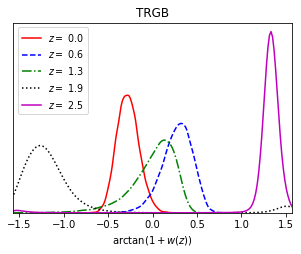

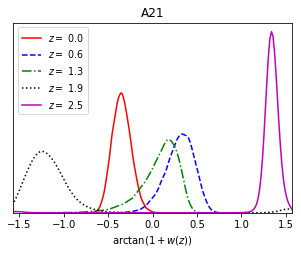

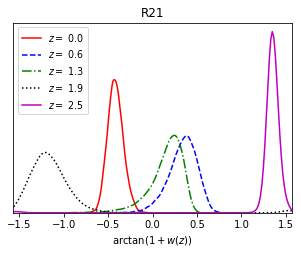

In [19]:
def plot_w_cb(H0_prior, ls, fc, hatch):
    
    z = DE_cb[H0_prior]['z']
    wz = DE_cb[H0_prior]['wz']
    
    plt.plot(z, 1 + wz[:, 0], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z,
                     1 + wz[:, 0] - 2*wz[:, 1],
                     1 + wz[:, 0] + 2*wz[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_aw_cb(H0_prior, ls, fc, hatch):
    
    z = DE_cb[H0_prior]['z']
    awz = DE_cb[H0_prior]['awz']
    
    plt.plot(z, awz[:, 4], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z, awz[:, 5], awz[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

# DE EoS
fig = plt.figure()
plot_w_cb('P18', ls = '-', fc = 'r', hatch = '-')
plot_w_cb('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_w_cb('A21', ls = '-.', fc = 'g', hatch = '|')
plot_w_cb('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('$1 + w(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max*0.4*0.8)
plt.ylim(-2, 2)
plt.show()

# compactified DE EoS
fig = plt.figure()
plot_aw_cb('P18', ls = '-', fc = 'r', hatch = '-')
plot_aw_cb('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_aw_cb('A21', ls = '-.', fc = 'g', hatch = '|')
plot_aw_cb('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('arctan($1 + w(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# posteriors at sample redshifts
for H0_prior in H0_priors:
    
    awz_samps = DE_cb[H0_prior]['awz_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(awz_samps)):
        z_i = np.round(awz_samps[i][0], 1)
        sns.kdeplot(awz_samps[i][1], color = cl_list[i],
                    linestyle = ls_list[i],
                    ax = ax, common_norm = True,
                    label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
        
    plt.show()

So that's it. We move on to nonparametric reconstruction in the next section.

### 3. Nonparametric reconstruction of DE

We feature the Gaussian processes to reconstruct the Hubble function $H(z)$ in a nonparameteric manner. From this, we also obtain the dark energy equation of state. Here is our GP code taking the Matern($\nu = 5/2$) kernel as an input.

In [20]:
class Mnu:
    '''class for the M52-based GP predictions
    
    k(r) = A^2*\exp(-\sqrt{5}*r/l)*(1 + \sqrt{5}*r/l + 5*(r^2)/(3*(l^2)))
    r = |x - y|
    
    input:
    l = length scale
    A = amplitude/height
    '''
    
    def __init__(self, l, A):
        self.length = l
        self.height = A
        
    def kernel(self, x, y):
        '''The Matern(nu = 5/2) kernel'''
        r = np.sqrt((x - y)**2)
        return (self.height**2)* \
               np.exp(-np.sqrt(5)*r/self.length)* \
               (1 + np.sqrt(5)*r/self.length + 5*(r**2)/(3*(self.length**2)))
            
    def k_plus_c_inv(self, Z, C):
        k_ZZ = np.array([[self.kernel(z_i, z_j) \
                          for z_i in Z]
                         for z_j in Z])
        return np.linalg.inv(k_ZZ + C)
    
    def cov(self, Z, C, Zs):
        '''returns the covariance matrix at Zs
        
        note: Zs must be an array'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        term_1 = np.array([[self.kernel(z_i, z_j) \
                            for z_i in Zs] \
                           for z_j in Zs])
        term_2 = np.array([[-(self.kernel(z_i, Z) @ \
                              kpc_inv @ \
                              self.kernel(Z, z_j)) \
                            for z_i in Zs] \
                           for z_j in Zs])
        return term_1 + term_2
    
    def var(self, Z, C, Zs):
        '''returns the variance at Zs
        
        note: Zs must be an array'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        term_1 = np.array([self.kernel(zs, zs)
                           for zs in Zs])
        term_2 = np.array([-(self.kernel(zs, Z) @ \
                             kpc_inv @ \
                             self.kernel(Z, zs)) \
                           for zs in Zs])
        return term_1 + term_2
    
    def get_logmlike(self, Z, Y, C):
        '''returns the GP log-marginal likelihood'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        kpc = np.linalg.inv(kpc_inv)
        kpc_det = np.linalg.det(kpc)
        Ys = np.array([(self.kernel(zs, Z) @ kpc_inv \
                        @ Y) for zs in Z])
        delta_y = Y
        return -0.5*(delta_y @ kpc_inv @ delta_y) \
               -0.5*np.log(kpc_det) \
               -0.5*len(Z)*np.log(2*np.pi)
    
    def predict(self, Z, Y, C, Zs, with_cov = False):
        kpc_inv = self.k_plus_c_inv(Z, C)
        mean = np.array([(self.kernel(zs, Z) @ kpc_inv \
                          @ Y) for zs in Zs])
        var_zz = self.var(Z, C, Zs)
        if with_cov == False:
            return {'z': Zs, 'Y': mean, 'varY': var_zz}
        else:
            cov_zz = self.cov(Z, C, Zs)
            return {'z': Zs, 'Y': mean, 'covY': cov_zz}
    
    # next functions: for reconstructing H'(z)

    def Dx_kRBF(self, x, y):
        '''returns the derivative of the M52 kernel
        with respect to x'''
        l = self.length
        A = self.height
        r = np.sqrt((x - y)**2)
        sgn = np.sign(x - y)
        return -5*(A**2)*np.exp(-np.sqrt(5)*r/l)*r*(l + np.sqrt(5)*r)*sgn/(3*(l**3))

    def Dy_kRBF(self, x, y):
        '''returns the derivative of the M52 kernel
        with respect to y'''
        return -self.Dx_kRBF(x, y)

    def Dxy_kRBF(self, x, y):
        '''returns the 2nd derivative of the M52 kernel
        with respect to x and y'''
        l = self.length
        A = self.height
        eps = 1e-20
        d = x - y
        r = np.sqrt(d**2 + eps)
        sgn = d/np.sqrt(d**2 + eps)
        r_xy = eps/((d**2 + eps)**(3/2))
        term_1 = ((l**2) + np.sqrt(5)*l*r - 5*(r**2))*(sgn**2)
        term_2 = l*r*(l + np.sqrt(5)*r)*r_xy
        return 5*(A**2)*np.exp(-np.sqrt(5)*r/l)*(term_1 + term_2)/(3*(l**4))

    # master function for obtaining f'(x) and cov[f'(x)]

    def df1_ave(self, Z, Y, C, Zs):
        '''returns the prediction mean of Y'(z) for an M52 kernel
        of length l and height A with training points (Z, Y)'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([(self.Dx_kRBF(zs, Z) @ kpc_inv @ Y) for zs in Zs])

    def df1_var(self, Z, C, Zs):
        '''returns the variances of Y'(z) for an M52 kernel
        of length l and height A with training points (Z, Y).'''
        kpc_inv = self.k_plus_c_inv(Z, C)
        return np.array([self.Dxy_kRBF(zs, zs) \
                         - (self.Dx_kRBF(zs, Z) @ kpc_inv @ self.Dy_kRBF(Z, zs)) \
                         for zs in Zs])

    def df_predict(self, Z, Y, C, Zs):
        '''Returns the derivative of the GP Y'(z) 
        for an M52 kernel of length scale l and height A'''
        return {'z': Zs, 'd1Y': self.df1_ave(Z, Y, C, Zs),
                'vard1Y': self.df1_var(Z, C, Zs)}

    def cov_fn_fm(self, Z, Y, C, zs):
        '''Returns the 2x2 covariance matrix of a GP
        and its first derivative at zs (single point) with RBF(l, A).
        
        Training data: (Z, Y, C) '''
        kpc_inv = self.k_plus_c_inv(Z, C)

        # 00-term
        term_1 = self.kernel(zs, zs)
        term_2 = -(self.kernel(zs, Z) @ kpc_inv @ self.kernel(Z, zs))
        cov_f0_f0 = term_1 + term_2

        # 11-term
        K10 = self.Dx_kRBF(zs, Z)
        K01 = self.Dy_kRBF(Z, zs)
        K11 = self.Dxy_kRBF(zs, zs)
        cov_f1_f1 = K11 - (K10 @ kpc_inv @ K01)

        # 01-term: cross-correlation
        K01_cc = self.Dy_kRBF(zs, zs)
        K00_cc = self.kernel(zs, Z)
        K01_cc_zzstar = self.Dy_kRBF(Z, zs)

        cov_f0_f1 = K01_cc - (K00_cc @ kpc_inv @ K01_cc_zzstar)

        return np.array([[cov_f0_f0, cov_f0_f1], \
                         [cov_f0_f1, cov_f1_f1]])

We then set this up to reconstruct the Hubble function given the CC data. This is done by fixing the GP log-marginal likelihood and optimizing this to obtain the kernel's hyperperameters. The next line does this.

In [21]:
def gp_logmlike_cc(l, A, H0_prior):
    '''returns the GP log-marginal likelihood for CC data'''
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    mnu = Mnu(l, A)
    z_cc_wH0Prior = np.append(np.array([0]), z_cc)
    Hz_cc_wH0Prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_wH0Prior = np.append(np.array([H0_std]), sigHz_cc)
    return mnu.get_logmlike(z_cc_wH0Prior, Hz_cc_wH0Prior,
                            np.diag(sigHz_cc_wH0Prior**2))

hps = {} # hyperparameters per H0 prior
for H0_prior in H0_priors:
    def gp_nlogmlike_cc(x):
        '''to be minimized'''
        return -gp_logmlike_cc(x[0], x[1], H0_prior)
    mnmz = minimize(gp_nlogmlike_cc,
                    [2, 130], method = 'Nelder-Mead',
                    tol = 1e-7)
    hp_opt = mnmz.x
    hps[H0_prior] = {'l': hp_opt[0], 'A': hp_opt[1]}
    print(H0_prior)
    print('success : ', mnmz.success)
    print(mnmz.message)
    print('logmlike : ', gp_logmlike_cc(hp_opt[0], hp_opt[1], H0_prior))
    print(hp_opt)

P18
success :  True
Optimization terminated successfully.
logmlike :  -205.06799786158993
[  4.56736339 191.26993967]
TRGB
success :  True
Optimization terminated successfully.
logmlike :  -205.35328032545897
[  3.98502341 180.30543372]
A21
success :  True
Optimization terminated successfully.
logmlike :  -205.57907332818988
[  3.66092208 175.57971011]
R21
success :  True
Optimization terminated successfully.
logmlike :  -205.84387950337344
[  3.35467374 172.24529988]


Here is a quick check of the above results with the GP regressor of ``scikit``.

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (Matern, ConstantKernel)

z_min = 0
z_max = 2.5
n_div = 250
z_rec = np.linspace(z_min, z_max, n_div)

for H0_prior in H0_priors:

    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    
    z_cc_prior = np.append(np.array([0]), z_cc)
    Hz_cc_prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_prior = np.append(np.array([H0_std]), sigHz_cc)
    
    gp = GaussianProcessRegressor(kernel = ConstantKernel()*Matern(nu = 5/2),
                                  alpha = sigHz_cc_prior**2,
                                  n_restarts_optimizer = 10)
    gp.fit(z_cc_prior.reshape(-1, 1), Hz_cc_prior)
    Hz_skl, sigHz_skl = gp.predict(z_rec.reshape(-1, 1), return_std = True)
    
    print("\nLearned kernel: %s" % gp.kernel_)
    print("Log-marginal-likelihood: %.3f"
          % gp.log_marginal_likelihood(gp.kernel_.theta))
    print(H0_prior, ': H0 =', Hz_skl[0], '+/-', sigHz_skl[0])


Learned kernel: 191**2 * Matern(length_scale=4.57, nu=2.5)
Log-marginal-likelihood: -205.068
P18 : H0 = 67.39089940087229 +/- 0.49491843819989156

Learned kernel: 180**2 * Matern(length_scale=3.99, nu=2.5)
Log-marginal-likelihood: -205.353
TRGB : H0 = 69.39962845437674 +/- 1.698670257015088

Learned kernel: 176**2 * Matern(length_scale=3.66, nu=2.5)
Log-marginal-likelihood: -205.579
A21 : H0 = 70.98001179127431 +/- 1.6431666571568435

Learned kernel: 172**2 * Matern(length_scale=3.35, nu=2.5)
Log-marginal-likelihood: -205.844
R21 : H0 = 72.81704375291719 +/- 1.0108613004468154


The reconstructed Hubble function per $H_0$ prior is shown below.

Hubble parameter
P18 : H0 = 67.39089933091502 +/- 0.494918491595107
TRGB : H0 = 69.39962911509834 +/- 1.69867033329683
A21 : H0 = 70.98001073033086 +/- 1.6431665277969683
R21 : H0 = 72.81704351928339 +/- 1.0108612652010838



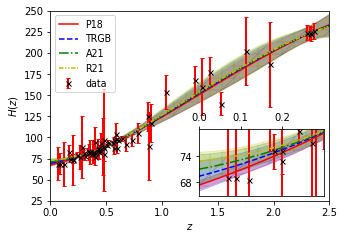

In [23]:
z_min = 0
z_max = 2.5
n_div = 80
z_rec = np.linspace(z_min, z_max, n_div)

fig, ax = plt.subplots(figsize = (5, 3.5))
ix = inset_axes(ax, width = '45%', height = '35%',
                loc = 'lower right')

# plot CC data in both main and inset frames
ax.errorbar(z_cc, Hz_cc, yerr = sigHz_cc, label = 'data',
            fmt = 'kx', markersize = 5,
            ecolor = 'red', elinewidth = 2, capsize = 2)
ix.errorbar(z_cc, Hz_cc, yerr = sigHz_cc,
            fmt = 'kx', markersize = 5,
            ecolor = 'red', elinewidth = 2, capsize = 2)

lst_list = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))]
clr_list = ['r', 'b', 'g', 'y']
htc_list = ['-', '/', '|', '\\']
print('Hubble parameter')
for H0_prior in H0_priors:
    H0_priors_list = list(H0_priors.keys())
    idx = H0_priors_list.index(H0_prior)
    mnu = Mnu(hps[H0_prior]['l'], hps[H0_prior]['A'])
    
    # reconstruction
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    z_cc_wH0Prior = np.append(np.array([0]), z_cc)
    Hz_cc_wH0Prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_wH0Prior = np.append(np.array([H0_std]), sigHz_cc)
    rec = mnu.predict(z_cc_wH0Prior, Hz_cc_wH0Prior,
                      np.diag(sigHz_cc_wH0Prior**2), z_rec)
    # GP reconstruction from SN, BAO, CC
    print(H0_prior, ': H0 =', rec['Y'][0], '+/-', np.sqrt(rec['varY'][0]))
    ax.plot(z_rec, rec['Y'], color = clr_list[idx], linestyle = lst_list[idx], label = H0_prior)
    ax.fill_between(z_rec,
                    rec['Y'] - 2*np.sqrt(rec['varY']),
                    rec['Y'] + 2*np.sqrt(rec['varY']),
                    alpha = .2, facecolor = clr_list[idx],
                    edgecolor = clr_list[idx],
                    hatch = htc_list[idx])
    ix.plot(z_rec, rec['Y'], color = clr_list[idx], linestyle = lst_list[idx])
    ix.fill_between(z_rec,
                    rec['Y'] - 2*np.sqrt(rec['varY']),
                    rec['Y'] + 2*np.sqrt(rec['varY']),
                    alpha = .2, facecolor = clr_list[idx],
                    edgecolor = clr_list[idx],
                    hatch = htc_list[idx])
print()
ax.set_xlabel('$z$')
ax.set_ylabel('$H(z)$')
ax.legend(loc = 'upper left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
ax.set_ylim(25, 250)
ix.set_xlim(0, 0.3)
ix.set_xticks([0, 0.1, 0.2])
ix.xaxis.tick_top()
ix.set_ylim(65, 80)
ix.set_yticks([68, 74])
ix.xaxis.set_tick_params(labelsize = 10)
ix.yaxis.set_tick_params(labelsize = 10)
plt.show()

With this, and a prior for the matter density, we can now reconstruct the dark energy density. We meet this goal by using Monte Carlo error propagation for the uncertainties. This is necessary in order to fully account for the covariance between $H(z)$ and $H'(z)$ that is inherent in the GP.

In [24]:
def w_de(z, Hz, Hpz, H0, om0):
    '''returns the dark energy equation of state'''
    return Hz*(3*Hz - 2*Hpz*(1 + z))/ \
           (3*(-(Hz**2) + (H0**2)*om0*((1 + z)**3)))

def reconstruct_DE_gp(H0_prior, om0, sigom0, z_rec, n_s = 1000):
    '''returns the mean and std of X(z) given H(z) per H0 prior    
    input:
    H0_prior = ('R21', 'TRGB', 'P18')
    om0 = matter energy fraction
    sigom0 = uncertainty in om0
    n_s = sampling size, default: n_s = 1000
    '''
    
    # reconstruction
    mnu = Mnu(hps[H0_prior]['l'], hps[H0_prior]['A'])
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    z_cc_wH0Prior = np.append(np.array([0]), z_cc)
    Hz_cc_wH0Prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_wH0Prior = np.append(np.array([H0_std]), sigHz_cc)
    rec = mnu.predict(z_cc_wH0Prior, Hz_cc_wH0Prior,
                      np.diag(sigHz_cc_wH0Prior**2), z_rec)
    drec = mnu.df_predict(z_cc_wH0Prior, Hz_cc_wH0Prior,
                          np.diag(sigHz_cc_wH0Prior**2), z_rec)
    Hz = rec['Y']
    sigHz = np.sqrt(rec['varY'])
    H0 = Hz[0]
    sigH0 = sigHz[0]
    Hpz = drec['d1Y']
    sigHpz = drec['vard1Y']
    
    # GP covariance between H(z) and H'(z)
    cov_Hz_Hpz = np.array([mnu.cov_fn_fm(z_cc_wH0Prior, Hz_cc_wH0Prior, \
                                         np.diag(sigHz_cc_wH0Prior**2), zs) \
                          for zs in z_rec])
    
    # prepare mean and cov of full parameters at each redshift
    ave_params = [np.array([Hz[i], Hpz[i], H0, om0])
                  for i in np.arange(0, len(z_rec))]
    cov_params = [block_diag(C, sigH0**2, sigom0**2)
                  for C in cov_Hz_Hpz]
    
    Xz = np.zeros((len(z_rec), 2))
    Xpz = np.zeros((len(z_rec), 2))
    wz = np.zeros((len(z_rec), 2))
    awz = np.zeros((len(z_rec), 7))
    
    # sample redshifts to get DE EoS posterior
    awz_z_samps = []
    i_samps = [int(len(z_rec)*x) for x in np.linspace(0, 1, 5)]
    if len(z_rec) in i_samps:
        len_z_index = i_samps.index(len(z_rec))
        i_samps[len_z_index] = len(z_rec) - 1
    
    for i in np.arange(0, len(z_rec)):
        
        z_i = z_rec[i]
        X_samps = np.zeros(n_s)
        Xp_samps = np.zeros(n_s)
        w_samps = np.zeros(n_s)
        aw_samps = np.zeros(n_s)
        for j in np.arange(0, n_s): # jth random draw at redshift z_i
            
            Hz_j, Hpz_j, H0_j, om0h2_j = MN(ave_params[i], cov_params[i])
            om0_j = om0h2_j/((H0_j/100)**2)
            X_samps[j] = ((Hz_j/H0)**2 - om0_j*((1 + z_i)**3))/(1 - om0_j)
            Xp_samps[j] = (3*((1 + z_i)**2)*om0_j - 2*Hz_j*Hpz_j/(H0_j**2))/(om0_j - 1)
            w_de_j = w_de(z_i, Hz_j, Hpz_j, H0_j, om0_j)
            w_samps[j] = w_de_j
            aw_samps[j] = np.arctan(1 + w_de_j)
            
        Xz[i][0] = np.mean(X_samps)
        Xz[i][1] = np.std(X_samps)
        
        Xpz[i][0] = np.mean(Xp_samps)
        Xpz[i][1] = np.std(Xp_samps)
        
        wz[i][0] = np.mean(w_samps)
        wz[i][1] = np.std(w_samps)
        
        awz[i][0] = np.mean(aw_samps)
        awz[i][1] = np.std(aw_samps)
        awz[i][2] = st.skew(aw_samps) 
        awz[i][3] = st.kurtosis(aw_samps, fisher = True)
        awz[i][4] = np.percentile(aw_samps, 50) # median of awz
        awz[i][5] = np.percentile(aw_samps, 50 - 34.1)
        awz[i][6] = np.percentile(aw_samps, 50 + 34.1)
        
        if i in i_samps:
            awz_z_samps.append([z_rec[i], aw_samps])
            
    return z_rec, Xz, Xpz, wz, awz, awz_z_samps

# predicting X(z) with MC error propagation
n_s = 1000
DE_gp = {}

om0_prior = om0_priors['P18']
for H0_prior in H0_priors:
    z, Xz, Xpz, wz, awz, awz_z_samps \
    = reconstruct_DE_gp(H0_prior, om0_prior['ave'], om0_prior['std'],
                        z_rec = np.linspace(z_min, z_max, 100), n_s = n_s)
    DE_dict = {}
    DE_dict['z'] = z
    DE_dict['Xz'] = Xz
    DE_dict['Xpz'] = Xpz
    DE_dict['wz'] = wz
    DE_dict['awz'] = awz
    DE_dict['awz_samps'] = awz_z_samps
    DE_gp[H0_prior] = DE_dict

The plots of $X(z)$ per prior is shown below.

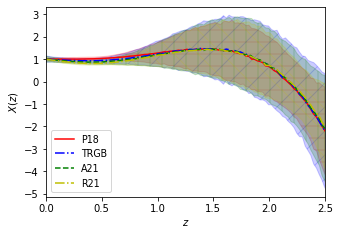

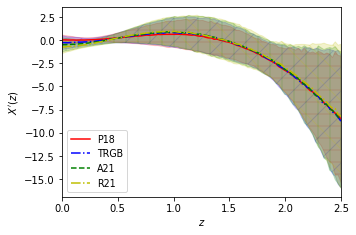

In [25]:
fig, ax = plt.subplots(figsize = (5, 3.5))

clr =['r', 'b', 'g', 'y']
lst =['-', '-.','--', '-.', (0, (3, 1, 1, 1, 1, 1))]
htc =['-', '/', '|', '\\']

for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_gp[H0_prior]['z']
    Xz = DE_gp[H0_prior]['Xz'][:, 0]
    sigXz = DE_gp[H0_prior]['Xz'][:, 1]
    
    # plot X(z) reconstruction
    plt.plot(z, Xz, color = clr[i], linestyle = lst[i], label = H0_prior)
    plt.fill_between(z, Xz - 2*sigXz, Xz + 2*sigXz,
                     alpha = .2, facecolor = clr[i],
                     edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

# plot X'(z) statistic
fig, ax = plt.subplots(figsize = (5, 3.5))
for i in np.arange(0, len(H0_priors)):
    
    H0_prior = list(H0_priors.keys())[i]
    z = DE_gp[H0_prior]['z']
    Xpz = DE_gp[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_gp[H0_prior]['Xpz'][:, 1]
    
    # plot X(z) reconstruction
    plt.plot(z, Xpz, color = clr[i], linestyle = lst[i], label = H0_prior)
    plt.fill_between(z, Xpz - 2*sigXpz, Xpz + 2*sigXpz,
                     alpha = .2, facecolor = clr[i],
                     edgecolor = clr[i], hatch = htc[i])
ax.set_xlabel('$z$')
ax.set_ylabel('$X^\prime(z)$')
ax.legend(loc = 'lower left', prop = {'size': 9.5})
ax.set_xlim(z_min, z_max)
plt.show()

The reconstructed DE EoS, the compactified EoS, and its posteriors at sample redshifts are presented below.

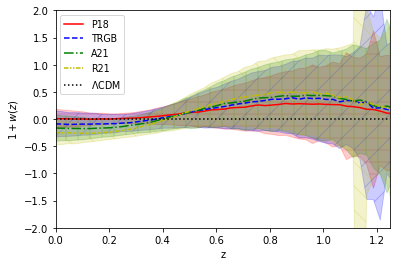

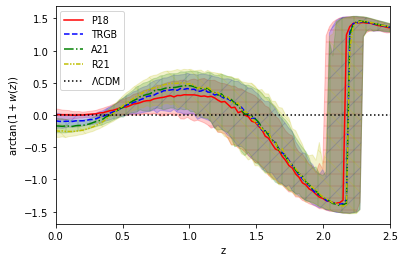

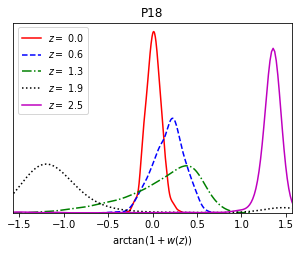

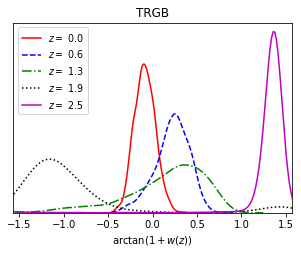

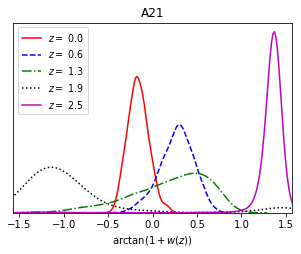

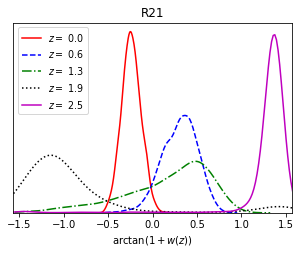

In [26]:
def plot_w_gp(H0_prior, ls, fc, hatch):
    
    z = DE_gp[H0_prior]['z']
    wz = DE_gp[H0_prior]['wz']
    
    plt.plot(z, 1 + wz[:, 0], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z,
                     1 + wz[:, 0] - 2*wz[:, 1],
                     1 + wz[:, 0] + 2*wz[:, 1],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)
    
def plot_aw_gp(H0_prior, ls, fc, hatch):
    
    z = DE_gp[H0_prior]['z']
    awz = DE_gp[H0_prior]['awz']
    
    plt.plot(z, awz[:, 4], linestyle = ls, color = fc, label = H0_prior)
    plt.fill_between(z, awz[:, 5], awz[:, 6],
                     alpha = .2, facecolor = fc,
                     edgecolor = fc, hatch = hatch)

# DE EoS
fig = plt.figure()
plot_w_gp('P18', ls = '-', fc = 'r', hatch = '-')
plot_w_gp('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_w_gp('A21', ls = '-.', fc = 'g', hatch = '|')
plot_w_gp('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('$1 + w(z)$')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max*0.5)
plt.ylim(-2, 2)
plt.show()

# compactified DE EoS
fig = plt.figure()
plot_aw_gp('P18', ls = '-', fc = 'r', hatch = '-')
plot_aw_gp('TRGB', ls = '--', fc = 'b', hatch = '/')
plot_aw_gp('A21', ls = '-.', fc = 'g', hatch = '|')
plot_aw_gp('R21', ls = (0, (3, 1, 1, 1, 1, 1)), fc = 'y', hatch = '\\')
plt.plot(np.linspace(z_min, z_max, n_div), np.array([0]*n_div),
         'k:', markersize = 4, label = r'$\Lambda$CDM')
plt.xlabel('z')
plt.ylabel('arctan($1 + w(z)$)')
plt.legend(loc = 'upper left', prop = {'size': 9.5})
plt.xlim(z_min, z_max)
plt.show()

# posteriors at sample redshifts
for H0_prior in H0_priors:
    
    awz_samps = DE_gp[H0_prior]['awz_samps']
    
    fig, ax = plt.subplots(figsize = (5, 3.5))
    cl_list = ['r', 'b', 'g', 'k', 'm']
    ls_list = ['-', '--', '-.', ':', '-']
    for i in np.arange(0, len(awz_samps)):
        z_i = np.round(awz_samps[i][0], 1)
        sns.kdeplot(awz_samps[i][1], color = cl_list[i],
                    linestyle = ls_list[i],
                    ax = ax, common_norm = True,
                    label = '$z =$ ' + str(z_i))
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_title(H0_prior)
    ax.set_xlabel('arctan($1 + w(z)$)')
    ax.set_xlim(-np.pi/2, np.pi/2)
    ax.set_yticks([])
    ax.set_ylabel('')
    plt.show()

We move on to the final and most important section of this notebook.

### 4. Assessment of parametric and nonparameteric reconstruction of dark energy

In this section, we consider the results from the parametric and nonparametric reconstructions of dark energy and compute statistical measures in order to assess their performance in representing the Hubble data.

We start by comparing the visual representations of DE. For this, we prepare the following plotting functions for the parameteric and GP methods. The reconstructions for each method are then plotted for each $H_0$ prior.

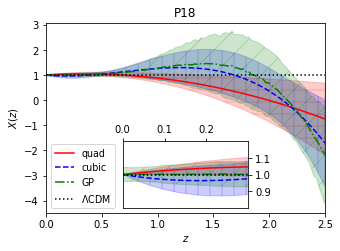

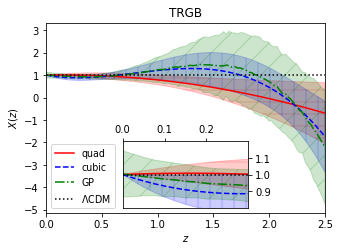

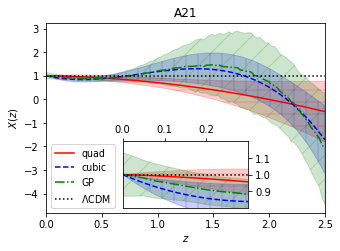

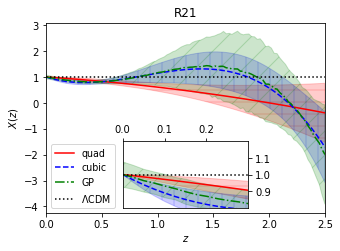

In [27]:
def plot_Xz_qd(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the quadratic parametrized DE from the best fit'''
    z = DE_qd[H0_prior]['z']
    Xz = DE_qd[H0_prior]['Xz'][:, 0]
    sigXz = DE_qd[H0_prior]['Xz'][:, 1]

    ax.plot(z, Xz, clr + lst, label = 'quad')
    ax.fill_between(z, Xz - 2*sigXz, Xz + 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    ix.plot(z, Xz, clr + lst, label = 'quad')
    ix.fill_between(z, Xz - 2*sigXz, Xz + 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    
def plot_Xz_cb(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the cub parametrized DE from the best fit'''
    
    z = DE_cb[H0_prior]['z']
    Xz = DE_cb[H0_prior]['Xz'][:, 0]
    sigXz = DE_cb[H0_prior]['Xz'][:, 1]

    ax.plot(z, Xz, clr + lst, label = 'cubic')
    ax.fill_between(z, Xz - 2*sigXz, Xz + 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    ix.plot(z, Xz, clr + lst, label = 'cubic')
    ix.fill_between(z, Xz - 2*sigXz, Xz + 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    
def plot_Xz_gp(H0_prior, clr, lst, htc):
    z = DE_gp[H0_prior]['z']
    Xz = DE_gp[H0_prior]['Xz'][:, 0]
    sigXz = DE_gp[H0_prior]['Xz'][:, 1]

    ax.plot(z, Xz, clr + lst, label = 'GP')
    ax.fill_between(z, Xz + 2*sigXz, Xz - 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    ix.plot(z, Xz, clr + lst, label = 'GP')
    ix.fill_between(z, Xz + 2*sigXz, Xz - 2*sigXz,
                    color = clr, alpha = 0.2, hatch = htc)
    
for H0_prior in H0_priors:
    fig, ax = plt.subplots(figsize = (5, 3.5))
    ix = inset_axes(ax, width = '45%', height = '35%',
                    loc = 'lower center')
    plot_Xz_qd(H0_prior, 'r', '-', '-')
    plot_Xz_cb(H0_prior, 'b', '--', '|')
    plot_Xz_gp(H0_prior, 'g', '-.', '/')
    ax.plot(z_rec, np.array([1]*len(z_rec)), 'k:', label = r'$\Lambda$CDM')
    ix.plot(z_rec, np.array([1]*len(z_rec)), 'k:', label = r'$\Lambda$CDM')
    ax.set_title(H0_prior)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$X(z)$')
    ax.legend(loc = 'lower left', prop = {'size': 9.5})
    ax.set_xlim(z_min, z_max)
    ix.set_xlim(0, 0.3)
    ix.set_xticks([0, 0.1, 0.2])
    ix.xaxis.tick_top()
    ix.yaxis.tick_right()
    ix.set_ylim(0.8, 1.2)
    ix.set_yticks([0.9, 1, 1.1])
    ix.xaxis.set_tick_params(labelsize = 10)
    ix.yaxis.set_tick_params(labelsize = 10)
    plt.show()

We also look into the $X'(z)$ statistic. The results are shown as follows.

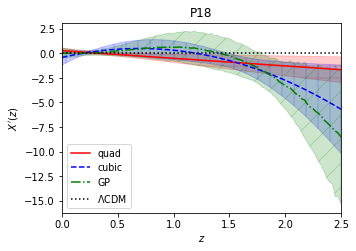

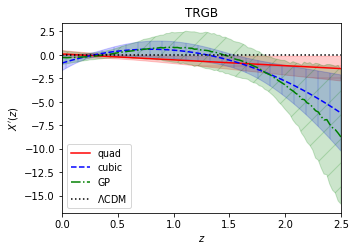

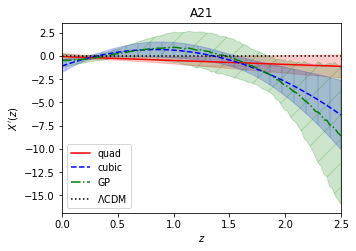

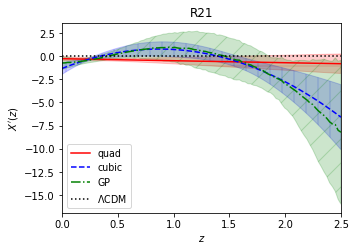

In [28]:
def plot_Xpz_qd(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the quadratic parametrized X'(z) from the best fit'''
    z = DE_qd[H0_prior]['z']
    Xpz = DE_qd[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_qd[H0_prior]['Xpz'][:, 1]

    ax.plot(z, Xpz, clr + lst, label = 'quad')
    ax.fill_between(z, Xpz - 2*sigXpz, Xpz + 2*sigXpz,
                    color = clr, alpha = 0.2, hatch = htc)
    
def plot_Xpz_cb(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the cub parametrized X'(z) from the best fit'''
    
    z = DE_cb[H0_prior]['z']
    Xpz = DE_cb[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_cb[H0_prior]['Xpz'][:, 1]

    ax.plot(z, Xpz, clr + lst, label = 'cubic')
    ax.fill_between(z, Xpz - 2*sigXpz, Xpz + 2*sigXpz,
                    color = clr, alpha = 0.2, hatch = htc)
    
def plot_Xpz_gp(H0_prior, clr, lst, htc):
    z = DE_gp[H0_prior]['z']
    Xpz = DE_gp[H0_prior]['Xpz'][:, 0]
    sigXpz = DE_gp[H0_prior]['Xpz'][:, 1]

    ax.plot(z, Xpz, clr + lst, label = 'GP')
    ax.fill_between(z, Xpz + 2*sigXpz, Xpz - 2*sigXpz,
                    color = clr, alpha = 0.2, hatch = htc)
    
for H0_prior in H0_priors:
    fig, ax = plt.subplots(figsize = (5, 3.5))
    plot_Xpz_qd(H0_prior, 'r', '-', '-')
    plot_Xpz_cb(H0_prior, 'b', '--', '|')
    plot_Xpz_gp(H0_prior, 'g', '-.', '/')
    ax.plot(z_rec, np.array([0]*len(z_rec)), 'k:', label = r'$\Lambda$CDM')
    ix.plot(z_rec, np.array([0]*len(z_rec)), 'k:', label = r'$\Lambda$CDM')
    ax.set_title(H0_prior)
    ax.set_xlabel('$z$')
    ax.set_ylabel('$X^\prime(z)$')
    ax.legend(loc = 'lower left', prop = {'size': 9.5})
    ax.set_xlim(z_min, z_max)
    plt.show()

In addition, here are the DE EoS reconstructions per method per $H_0$ prior.

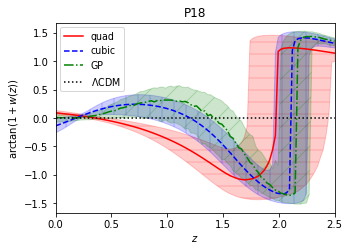

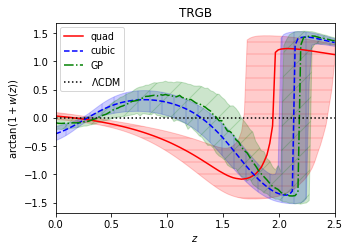

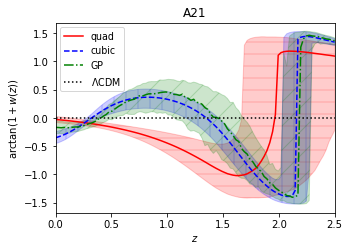

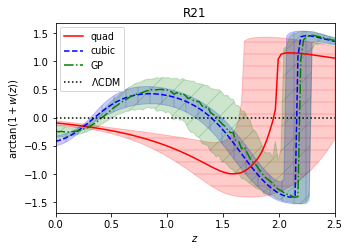

In [29]:
def plot_wz_qd(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the quadratic parametrized DE from the best fit'''
    z = DE_qd[H0_prior]['z']
    awz = DE_qd[H0_prior]['awz']
    
    ax.plot(z, awz[:, 4], clr + lst, label = 'quad')
    ax.fill_between(z, awz[:, 5], awz[:, 6],
                    alpha = .2, facecolor = clr,
                    edgecolor = clr, hatch = htc)
    
def plot_wz_cb(H0_prior, clr, lst, htc, zm = 2.36):
    '''plots the cub parametrized DE from the best fit'''
    z = DE_cb[H0_prior]['z']
    awz = DE_cb[H0_prior]['awz']
    
    ax.plot(z, awz[:, 4], clr + lst, label = 'cubic')
    ax.fill_between(z, awz[:, 5], awz[:, 6],
                    alpha = .2, facecolor = clr,
                    edgecolor = clr, hatch = htc)
    
def plot_wz_gp(H0_prior, clr, lst, htc):
    z = DE_gp[H0_prior]['z']
    awz = DE_gp[H0_prior]['awz']
    
    ax.plot(z, awz[:, 4], clr + lst, label = 'GP')
    ax.fill_between(z, awz[:, 5], awz[:, 6],
                    alpha = .2, facecolor = clr,
                    edgecolor = clr, hatch = htc)
    
for H0_prior in H0_priors:
    fig, ax = plt.subplots(figsize = (5, 3.5))
    plot_wz_qd(H0_prior, 'r', '-', '-')
    plot_wz_cb(H0_prior, 'b', '--', '|')
    plot_wz_gp(H0_prior, 'g', '-.', '/')
    ax.plot(z_rec, np.array([0]*len(z_rec)), 'k:', label = r'$\Lambda$CDM')
    ax.set_title(H0_prior)
    ax.set_xlabel('$z$')
    ax.set_ylabel(r'$\arctan(1 + w(z))$')
    ax.legend(loc = 'upper left', prop = {'size': 9.5})
    ax.set_xlim(z_min, z_max)
    plt.show()

Now, as a first measure of the statistical relevance of each reconstruction method, we compute the *bare* chi-squared statistic for the CC data:
\begin{equation}
\chi^2_\text{CC} = \sum_z \left( \dfrac{ H_\text{rec}(z) - H_\text{CC}(z) }{\sigma_{H, \text{CC}}(z)} \right)^2 .
\end{equation}
This computation is setup in the next line.

In [30]:
def bare_chi2_cc_qd(H0_prior, zm = 2.36):
    '''returns the bare chi-squared for quadratic parametrized DE'''
    idx = list(H0_priors.keys()).index(H0_prior)
    H0 = np.mean(results_qd[idx][:, 0])
    om0 = np.mean(results_qd[idx][:, 1])
    f1 = np.mean(results_qd[idx][:, 2])
    f2 = np.mean(results_qd[idx][:, 3])
    model = H0*Ez_qd(z_cc, zm, om0, f1, f2)
    inv_sigma2 = 1/(sigHz_cc**2)
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    PRI = ((H0 - H0_ave)/H0_std)**2
    chi2 = np.sum(((Hz_cc - model)**2)*inv_sigma2) + PRI
    return chi2 + PRI

def bare_chi2_cc_cb(H0_prior, zm = 2.36):
    '''returns the bare chi-squared for cubic parameterized DE'''
    idx = list(H0_priors.keys()).index(H0_prior)
    H0 = np.mean(results_cb[idx][:, 0])
    om0 = np.mean(results_cb[idx][:, 1])
    f1 = np.mean(results_cb[idx][:, 2])
    f2 = np.mean(results_cb[idx][:, 3])
    f3 = np.mean(results_cb[idx][:, 4])
    model = H0*Ez_cb(z_cc, zm, om0, f1, f2, f3)
    inv_sigma2 = 1/(sigHz_cc**2)
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    PRI = ((H0 - H0_ave)/H0_std)**2
    chi2 = np.sum(((Hz_cc - model)**2)*inv_sigma2) + PRI
    return chi2 + PRI

def bare_chi2_cc_gp(H0_prior):
    '''returns the bare chi-squared for the GP reconstruction'''
    # reconstruction
    mnu = Mnu(hps[H0_prior]['l'], hps[H0_prior]['A'])
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    z_cc_wH0Prior = np.append(np.array([0]), z_cc)
    Hz_cc_wH0Prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_wH0Prior = np.append(np.array([H0_std]), sigHz_cc)
    rec = mnu.predict(z_cc_wH0Prior, Hz_cc_wH0Prior,
                      np.diag(sigHz_cc_wH0Prior**2), z_cc_wH0Prior)
    chi2 = np.sum(((rec['Y'] - Hz_cc_wH0Prior)/sigHz_cc_wH0Prior)**2)
    return chi2

It would be informative to also compare the results with $\Lambda$CDM. In this case, we sample over $H_0$ and $\Omega_{m0}$ by conveniently setting $x_1 = x_2 = 1$ in the quadratic model.

#### $\Lambda$CDM

Sampling $\Lambda$CDM over the same data set and priors.

searching the initial position ...
P18
minimization 0.5*chi2 [67.49735089  0.31348147]
Running MCMC...


100%|██████████| 4000/4000 [00:33<00:00, 119.50it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 67.51293363496958 + 0.3223706307714167 - 0.32400642810108593 
            $\Omega_m0$      = 0.31341572179303023 + 0.0035554898296886184 - 0.0035711013120825474
        
Mean acceptance fraction: 0.7129268292682926 34.39379334449768
searching the initial position ...
TRGB
minimization 0.5*chi2 [68.39360227  0.30500304]
Running MCMC...


100%|██████████| 4000/4000 [00:30<00:00, 130.95it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 68.36937485047727 + 0.6624092978014744 - 0.668644622048987 
            $\Omega_m0$      = 0.3052159216445942 + 0.00649759975045483 - 0.0063107913714144925
        
Mean acceptance fraction: 0.7088719512195121 31.96884250640869
searching the initial position ...
A21
minimization 0.5*chi2 [68.87253464  0.30061013]
Running MCMC...


100%|██████████| 4000/4000 [00:31<00:00, 126.68it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 68.82737090596262 + 0.6442812501276762 - 0.63984201314139 
            $\Omega_m0$      = 0.3010693184487765 + 0.006135989418171561 - 0.006061862530933437
        
Mean acceptance fraction: 0.7127134146341463 32.33378458023071
searching the initial position ...
R21
minimization 0.5*chi2 [70.54345401  0.28599257]
Running MCMC...


100%|██████████| 4000/4000 [00:30<00:00, 132.02it/s]


Done.
Removed no burn in
MCMC result:
            $H_0$ = 70.5496744128155 + 0.5151935753778076 - 0.5240022494180465 
            $\Omega_m0$      = 0.28603598920372286 + 0.004556123377405574 - 0.004603452494651605
        
Mean acceptance fraction: 0.7138719512195122 31.13837194442749


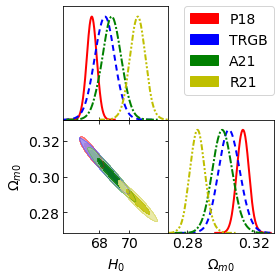

In [31]:
ndim, nwalkers = 2, 8
nburn = 100
nmcmc = 4000

dres = [0.03, 0.05]
burnin = 100
results_lcdm = []

samples_lcdm = {}
for H0_prior in H0_priors:
    def nloglike(x):
        '''LambdaCDM params: H0, om0 = x[0], x[1]'''
        return loglike_cc_qd(x[0], x[1], 1, 1, H0_priors[H0_prior], om0_priors['P18'])
    def chimint(x):
        return -nloglike(x)
    
    print('searching the initial position ...')
    print(H0_prior)
    rest = minimize(chimint, [70, 0.3], method = 'Nelder-Mead')
    print('minimization 0.5*chi2', rest.x)
    result = rest.x
    with Pool() as pool:
        start=time.time()
        sampler = emcee.EnsembleSampler(nwalkers, ndim, nloglike, pool = pool)

        pos0 = [result + dres*np.random.randn(ndim) for i in range(nwalkers)]

        print("Running MCMC...")
        pos1 = sampler.run_mcmc(pos0, nburn, rstate0 = np.random.get_state())
        sampler.run_mcmc(pos1, nmcmc, rstate0 = np.random.get_state(), progress = True)
        print("Done.")

        samps = sampler.chain[:, burnin:, :].reshape((-1, ndim))
        results_lcdm.append(samps)
        names = ["H0", "om0"]
        labels = ["H_0", "\Omega_{m0}"]

        samples_lcdm[H0_prior] = MCSamples(samples = samps, names = names, labels = labels)

        H0_mcmc, om0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), \
                          zip(*np.percentile(samps, [16, 50, 84], \
                                           axis=0)))
        print("""MCMC result:
            $H_0$ = {0[0]} + {0[1]} - {0[2]} 
            $\Omega_m0$      = {1[0]} + {1[1]} - {1[2]}
        """.format(H0_mcmc, om0_mcmc))

        print("Mean acceptance fraction:",
              np.mean(sampler.acceptance_fraction), time.time() - start)
        
g = plots.getSubplotPlotter()
g.settings.axes_labelsize = 17
g.settings.axes_fontsize = 17
g.settings.legend_fontsize = 17
g.triangle_plot([samples_lcdm['P18'], samples_lcdm['TRGB'], samples_lcdm['A21'], samples_lcdm['R21']], filled = True,
                legend_labels = ['P18', 'TRGB', 'A21', 'R21'], contour_colors = ['r', 'b', 'g', 'y'],
                contour_ls = ['-', '--', '-.', (0, (3, 1, 1, 1, 1, 1))], contour_lws = 2, legend_loc = 'upper right')

The bare chi-squared and $\Delta \chi^2 = \chi^2_{\Lambda\text{CDM}} - \chi^2_{\text{rec}}$ is computed per $H_0$ prior in the next line.

In [32]:
def bare_chi2_cc_lcdm(H0_prior):
    '''returns the bare chi-squared of LambdaCDM with CC data'''
    idx = list(H0_priors.keys()).index(H0_prior)
    H0 = np.mean(results_lcdm[idx][:, 0])
    om0 = np.mean(results_lcdm[idx][:, 1])
    model = H0*Ez_qd(z_cc, 2.36, om0, f1 = 1, f2 = 1)
    inv_sigma2 = 1/(sigHz_cc**2)
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    PRI = ((H0 - H0_ave)/H0_std)**2
    chi2 = np.sum(((Hz_cc - model)**2)*inv_sigma2) + PRI
    return chi2 + PRI

for H0_prior in H0_priors:
    print(H0_prior)
    print('LambdaCDM : chi^2 =', bare_chi2_cc_lcdm(H0_prior))
    print('quad : chi^2 =', bare_chi2_cc_qd(H0_prior))
    print('     : Delta chi^2', bare_chi2_cc_lcdm(H0_prior) - bare_chi2_cc_qd(H0_prior))
    print('cubic : chi^2 =', bare_chi2_cc_cb(H0_prior))
    print('      : Delta chi^2', bare_chi2_cc_lcdm(H0_prior) - bare_chi2_cc_cb(H0_prior))
    print('GP : chi^2 =', bare_chi2_cc_gp(H0_prior))
    print('   : Delta chi^2', bare_chi2_cc_lcdm(H0_prior) - bare_chi2_cc_gp(H0_prior))
    print()

P18
LambdaCDM : chi^2 = 37.66195016576808
quad : chi^2 = 30.63079585282155
     : Delta chi^2 7.0311543129465335
cubic : chi^2 = 27.036466778119593
      : Delta chi^2 10.62548338764849
GP : chi^2 = 26.63561380639859
   : Delta chi^2 11.026336359369491

TRGB
LambdaCDM : chi^2 = 38.57456646035056
quad : chi^2 = 32.10993376017688
     : Delta chi^2 6.464632700173681
cubic : chi^2 = 26.101549858753565
      : Delta chi^2 12.473016601596996
GP : chi^2 = 26.10203786152351
   : Delta chi^2 12.47252859882705

A21
LambdaCDM : chi^2 = 42.833897878105624
quad : chi^2 = 33.81548851138881
     : Delta chi^2 9.018409366716817
cubic : chi^2 = 25.659938250035218
      : Delta chi^2 17.173959628070406
GP : chi^2 = 25.838702070057906
   : Delta chi^2 16.99519580804772

R21
LambdaCDM : chi^2 = 60.001967936633854
quad : chi^2 = 36.395458514859264
     : Delta chi^2 23.60650942177459
cubic : chi^2 = 25.339751250112396
      : Delta chi^2 34.66221668652146
GP : chi^2 = 25.559318371488946
   : Delta chi^2 3

Now, to further assess the reconstructions, we consider two measures that take into account both uncertainties in the data and in the reconstructed Hubble function (see [2105.14332](https://arxiv.org/pdf/2105.14332.pdf)). These measures are given by
\begin{equation}
\mathcal{D}_1 = \sum_z \left( \dfrac{ H_\text{rec}(z) - H_\text{CC}(z) }{ \sqrt{ \sigma_{\text{rec}}(z)^2 + \sigma_{H, \text{CC}}(z)^2 }} \right)
\end{equation}
and
\begin{equation}
\mathcal{D}_2 = \sum_z \left( \dfrac{ H_\text{rec}(z) - H_\text{CC}(z) }{ \sqrt{ \sigma_{\text{rec}}(z)^2 + \sigma_{H, \text{CC}}(z)^2 }} \right)^2 .
\end{equation}
We present this in the following calculations for each method.

In [33]:
# baseline: LambdaCDM
def Dmetric_lcdm(iz, H0_prior, zm = 2.36):
    '''
    The option is the prior and if we consider upper or lower error bar.
    Depending on that, we set up best fit parameters and so do
    the reconstructed function. iz is the index of the redshift arange.
    '''
    idx = list(H0_priors.keys()).index(H0_prior)
    
    # H0 = mean value, sH0 = sigma_H0 upper error bar if case==1, sH0 lower error bar if case==2
    
    H0 = np.mean(samples_lcdm[H0_prior][0])
    sH0 = np.std(samples_lcdm[H0_prior][0])

    om = np.mean(samples_lcdm[H0_prior][1])
    som = np.std(samples_lcdm[H0_prior][1])

    z = z_cc[iz]
    Ez = Ez_qd(z, zm, om, f1 = 1, f2 = 1)
    Distance = Ez*H0 - Hz_cc[iz] # H_rec(z) - H_cc(z)
    sigHz = sigHz_cc[iz] # sigma_{H,CC}(z)
    
    # sigma_rec(z)
    var_H0 = sH0*Ez
    var_om = som*H0*((1 + z)**3 + Xz_qd(z, zm, f1 = 1, f2 = 1))
    var_Xz = 0
    
    sig_rec = var_H0**2 + var_om**2 + var_Xz**2 # already squared
    
    return Distance/np.sqrt(sig_rec + sigHz**2)

# quadratic parametrization D(z)
def sigma_qd(H0_prior, z, zm = 2.36):
    H0_priors_lst = list(H0_priors.keys())
    samples_result_i = H0_priors_lst.index(H0_prior)
    samples_result = results_qd[samples_result_i]
    f11 = ((-4*z**2) + (4*zm*z))/(zm**2)
    f22 = ((2*(z**2)) - (zm*z))/(zm**2)
    
    H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                              zip(*np.percentile(samples_result, [16, 50, 84], axis = 0)))
    
    f1, f2 = x1_mcmc[0], x2_mcmc[0]
    f1up, f1down = x1_mcmc[1], x2_mcmc[2]
    f2up, f2down  =  x1_mcmc[1], x2_mcmc[2]
    
    sigma_a = ((f1up + f1down)/2.)**2
    sigma_b = ((f2up + f2down)/2.)**2

    covm = samples_qd[H0_prior].cov()
    return np.sqrt((f11**2)*sigma_a + (f22**2)*sigma_b + 2*f11*f22*covm[3,2])

def Dmetric_quad(iz, H0_prior, zm = 2.36):
    '''
    The option is the prior and if we consider upper or lower error bar.
    Depending on that, we set up best fit parameters and so do
    the reconstructed function. iz is the index of the redshift arange.
    '''      
    idx = list(H0_priors.keys()).index(H0_prior)
    
    H0 = np.mean(samples_qd[H0_prior][0])
    sH0 = np.std(samples_qd[H0_prior][0])

    om = np.mean(samples_qd[H0_prior][1])
    som = np.std(samples_qd[H0_prior][1])

    x1 = np.mean(samples_qd[H0_prior][2])
    sx1 = np.std(samples_qd[H0_prior][2])
    
    x2 = np.mean(samples_qd[H0_prior][3])
    sx2 = np.std(samples_qd[H0_prior][3])

    z = z_cc[iz]
    Ez = Ez_qd(z, zm, om, x1, x2)
    Distance = Ez*H0 - Hz_cc[iz] # H_rec(z) - H_cc(z)
    sigHz = sigHz_cc[iz] # sigma_{H,CC}(z)
    
    # sigma_rec(z)
    
    var_H0 = sH0*Ez
    var_om = som*H0*((1 + z)**3 + Xz_qd(z, zm, x1, x2))
    var_Xz = sigma_qd(H0_prior, z, zm = zm)*H0
    
    sig_rec = var_H0**2 + var_om**2 + var_Xz**2 # already squared
    
    return Distance/np.sqrt(sig_rec + sigHz**2)

# cubic parametrization D(z)
def sigma_cb(H0_prior, z, zm = 2.36):

    H0_priors_lst = list(H0_priors.keys())
    samples_result_i = H0_priors_lst.index(H0_prior)
    samples_result = results_cb[samples_result_i]
    
    f11 = ((27*z**3) - (45*zm*z**2) + (18*z*zm**2))/(2*zm**3)
    f22 = ((-27*z**3) + (36*zm*z**2) - (9*z*zm**2))/(2*zm**3)
    f33 = ((9*z**3) - (9*zm*z**2) + (2*z*zm**2))/(2*zm**3)
    
    H0_mcmc, om0_mcmc, x1_mcmc, x2_mcmc, x3_mcmc = map(lambda v: (v[1], v[2] - v[1], v[1] - v[0]),
                                              zip(*np.percentile(samples_result, [16, 50, 84], axis = 0)))
    
    f1, f2, f3 = x1_mcmc[0], x2_mcmc[0], x3_mcmc[0]
    f1up, f1down = x1_mcmc[1], x1_mcmc[2]
    f2up, f2down  =  x2_mcmc[1], x2_mcmc[2]
    f3up, f3down = x3_mcmc[1], x3_mcmc[2]

    sigma_a = ((f1up + f1down)/2)**2
    sigma_b = ((f2up + f2down)/2)**2
    sigma_c = ((f3up + f3down)/2)**2

    covm = samples_cb[H0_prior].cov()

    return np.sqrt((f11**2)*sigma_a + (f22**2)*sigma_b \
                   + (f33**2)*sigma_c + 2*f11*f22*covm[3, 2] \
                   + 2*f11*f33*covm[4, 2] + 2*f33*f22*covm[4, 3])

def Dmetric_cubic(iz, H0_prior, zm = 2.36):
    '''
    The option is the prior and if we consider upper or lower error bar.
    Depending on that, we set up best fit parameters and so do
    the reconstructed function. iz is the index of the redshift arange.
    ''' 
    idx = list(H0_priors.keys()).index(H0_prior)
    
    H0 = np.mean(samples_cb[H0_prior][0])
    sH0 = np.std(samples_cb[H0_prior][0])

    om = np.mean(samples_cb[H0_prior][1])
    som = np.std(samples_cb[H0_prior][1])

    x1 = np.mean(samples_cb[H0_prior][2])
    sx1 = np.std(samples_cb[H0_prior][2])
    
    x2 = np.mean(samples_cb[H0_prior][3])
    sx2 = np.std(samples_cb[H0_prior][3])
    
    x3 = np.mean(samples_cb[H0_prior][4])
    sx3 = np.std(samples_cb[H0_prior][4])

    z = z_cc[iz]
    Ez = Ez_cb(z, zm, om, x1, x2, x3)
    Distance = Ez*H0 - Hz_cc[iz] # H_rec(z) - H_cc(z)
    sigHz = sigHz_cc[iz] # sigma_{H,CC}(z)
    
    # sigma_rec(z)
    
    var_H0 = sH0*Ez
    var_om = som*H0*((1 + z)**3 + Xz_cb(z, zm, x1, x2, x3))
    var_Xz = sigma_cb(H0_prior, z, zm = zm)*H0
    
    sig_rec = var_H0**2 + var_om**2 + var_Xz**2 # already squared
    
    return Distance/np.sqrt(sig_rec + sigHz**2)

def Dmetric_gp(iz, H0_prior):
    '''
    The option is the prior and if we consider upper or lower error bar.
    Depending on that, we set up best fit parameters and so do
    the reconstructed function. iz is the index of the redshift arange.
    '''
    mnu = Mnu(hps[H0_prior]['l'], hps[H0_prior]['A'])
    H0_ave = H0_priors[H0_prior]['ave']
    H0_std = H0_priors[H0_prior]['std']
    z_cc_wH0Prior = np.append(np.array([0]), z_cc)
    Hz_cc_wH0Prior = np.append(np.array([H0_ave]), Hz_cc)
    sigHz_cc_wH0Prior = np.append(np.array([H0_std]), sigHz_cc)
    rec = mnu.predict(z_cc_wH0Prior, Hz_cc_wH0Prior,
                      np.diag(sigHz_cc_wH0Prior**2), z_cc)
    Hz_rec = rec['Y']
    varHz_rec = rec['varY']

    Distance = Hz_rec - Hz_cc
    return Distance[iz]/np.sqrt(varHz_rec[iz] + (sigHz_cc[iz]**2))

Here are the results for $\mathcal{D}_1$ and $\mathcal{D}_2$:

In [34]:
for H0_prior in H0_priors:
    print(H0_prior)
    D = 0
    D2 = 0
    for iz in range(len(z_cc)):
        D += Dmetric_lcdm(iz, H0_prior)
        D2 += Dmetric_lcdm(iz, H0_prior)**2
    print('LambdaCDM : D1 =', D, ', D2 =', D2)
    D = 0
    D2 = 0
    for iz in range(len(z_cc)):
        D += Dmetric_quad(iz, H0_prior)
        D2 += Dmetric_quad(iz, H0_prior)**2
    print('Quadratic case : D1 =', D, ', D2 =', D2)
    D = 0
    D2 = 0
    for iz in range(len(z_cc)):
        D += Dmetric_cubic(iz, H0_prior)
        D2 += Dmetric_cubic(iz, H0_prior)**2
    print('Cubic case : D1 =', D, ', D2 =', D2)
    D = 0
    D2 = 0
    for iz in range(len(z_cc)):
        D += Dmetric_gp(iz, H0_prior)
        D2 += Dmetric_gp(iz, H0_prior)**2
    print('Gaussian processes : D1 =', D, ', D2 =', D2)
    print()

P18
LambdaCDM : D1 = -2.961055116431871 , D2 = 30.435392710667287
Quadratic case : D1 = -2.918219602370263 , D2 = 6.632676466270055
Cubic case : D1 = -2.7676857160320116 , D2 = 15.052367682754344
Gaussian processes : D1 = -2.190404579740667 , D2 = 25.200761275128595

TRGB
LambdaCDM : D1 = 1.155510510610763 , D2 = 24.24992424830103
Quadratic case : D1 = -2.235391073205892 , D2 = 6.255287144938826
Cubic case : D1 = -1.843064840448802 , D2 = 10.730621482130081
Gaussian processes : D1 = -1.0338665045417477 , D2 = 24.391603441756857

A21
LambdaCDM : D1 = 3.9788654671546526 , D2 = 25.17891815552081
Quadratic case : D1 = -1.7631609686877583 , D2 = 6.665387452642801
Cubic case : D1 = -1.2353210677779818 , D2 = 11.718643932728819
Gaussian processes : D1 = -0.2522076585080737 , D2 = 23.971817073648037

R21
LambdaCDM : D1 = 15.520792773436106 , D2 = 34.80312515446894
Quadratic case : D1 = -1.0094823768148011 , D2 = 8.37718808084305
Cubic case : D1 = -0.8396116261037366 , D2 = 14.141102894502456
G

Constraints on the dark energy equation of state at redshift $z = 0$ are presented below to end the notebook.

In [35]:
for H0_prior in H0_priors:
    print(H0_prior)
    print('quad : w(z) =', DE_qd[H0_prior]['wz'][:, 0][0], '+/-', DE_qd[H0_prior]['wz'][:, 1][0])
    print('cubic: w(z) =', DE_cb[H0_prior]['wz'][:, 0][0], '+/-', DE_cb[H0_prior]['wz'][:, 1][0])
    print('GP : w(z) =', DE_gp[H0_prior]['wz'][:, 0][0], '+/-', DE_gp[H0_prior]['wz'][:, 1][0])
    print()

P18
quad : w(z) = -0.9105858776542786 +/- 0.042269329227011945
cubic: w(z) = -1.1404784196422608 +/- 0.13016230235792478
GP : w(z) = -0.9905520145986113 +/- 0.08835865009410061

TRGB
quad : w(z) = -0.9672082697429607 +/- 0.062149848526798945
cubic: w(z) = -1.2905427740976916 +/- 0.13557843979284495
GP : w(z) = -1.0889102073431136 +/- 0.11969691303392883

A21
quad : w(z) = -1.0281403533266131 +/- 0.05361724368198204
cubic: w(z) = -1.3675138138125869 +/- 0.12027384227563347
GP : w(z) = -1.1654739915213215 +/- 0.12181374824776124

R21
quad : w(z) = -1.0944962234771451 +/- 0.03829458660862253
cubic: w(z) = -1.4475209738518986 +/- 0.10639851818496858
GP : w(z) = -1.2465347876202668 +/- 0.11493993439261613



### *References for the data*

**$H_0$ priors**

Planck collaboration, *Planck 2018 results. VI. Cosmological parameters*, Astron. Astrophys.
641 (2020) A6 [1807.06209](https://arxiv.org/abs/1807.06209).

W. L. Freedman et al., *The Carnegie-Chicago Hubble Program. VIII. An Independent
Determination of the Hubble Constant Based on the Tip of the Red Giant Branch*, Astrophys.
J. 882 (2019) 34 [1907.05922](https://arxiv.org/abs/1907.05922).

G. S. Anand, R. B. Tully, L. Rizzi, A. G. Riess and W. Yuan, *Comparing Tip of the Red Giant
Branch Distance Scales: An Independent Reduction of the Carnegie-Chicago Hubble Program
and the Value of the Hubble Constant*, [2108.00007](https://arxiv.org/abs/2108.00007).

**cosmic chronometers**

M. Moresco, L. Pozzetti, A. Cimatti, R. Jimenez, C. Maraston, L. Verde et al., *A 6%
measurement of the Hubble parameter at z ∼ 0.45: direct evidence of the epoch of cosmic
re-acceleration*, JCAP 05 (2016) 014 [1601.01701](https://arxiv.org/abs/1601.01701).

M. Moresco, *Raising the bar: new constraints on the Hubble parameter with cosmic
chronometers at z ∼ 2*, Mon. Not. Roy. Astron. Soc. 450 (2015) L16 [1503.01116](https://arxiv.org/abs/1503.01116).

C. Zhang, H. Zhang, S. Yuan, S. Liu, T.-J. Zhang and Y.-C. Sun, *Four new observational H(z)
data from luminous red galaxies in the Sloan Digital Sky Survey data release seven*, Research in
Astronomy and Astrophysics 14 (2014) 1221 [1207.4541](https://arxiv.org/abs/1207.4541).

D. Stern, R. Jimenez, L. Verde, M. Kamionkowski and S. A. Stanford, *Cosmic chronometers:
constraining the equation of state of dark energy. I: H(z) measurements*, JCAP 2010 (2010)
008 [0907.3149](https://arxiv.org/abs/0907.3149).

M. Moresco et al., *Improved constraints on the expansion rate of the Universe up to z$\sim$1.1 from
the spectroscopic evolution of cosmic chronometers*, JCAP 2012 (2012) 006 [1201.3609](https://arxiv.org/abs/1201.3609).

A. L. Ratsimbazafy, S. I. Loubser, S. M. Crawford, C. M. Cress, B. A. Bassett, R. C. Nichol
et al., *Age-dating Luminous Red Galaxies observed with the Southern African Large Telescope*,
Mon. Not. Roy. Astron. Soc. 467 (2017) 3239 [1702.00418](https://arxiv.org/abs/1702.00418).

**baryon acoustic oscillations**

C. Blake, S. Brough, M. Colless, C. Contreras, W. Couch, S. Croom et al., *The WiggleZ Dark
Energy Survey: joint measurements of the expansion and growth history at z $<$ 1*, Mon. Not.
Roy. Astron. Soc. 425 (2012) 405 [1204.3674](https://arxiv.org/abs/1204.3674).

C.-H. Chuang et al., *The clustering of galaxies in the SDSS-III Baryon Oscillation
Spectroscopic Survey: single-probe measurements and the strong power of normalized growth
rate on constraining dark energy*, Mon. Not. Roy. Astron. Soc. 433 (2013) 3559 [1303.4486](https://arxiv.org/abs/1303.4486).

BOSS collaboration, *Quasar-Lyman α Forest Cross-Correlation from BOSS DR11 : Baryon
Acoustic Oscillations*, JCAP 05 (2014) 027 [1311.1767](https://arxiv.org/abs/1311.1767).

BOSS collaboration, *Baryon acoustic oscillations in the Lyα forest of BOSS DR11 quasars*,
Astron. Astrophys. 574 (2015) A59 [1404.1801](https://arxiv.org/abs/1404.1801).

J. E. Bautista et al., *Measurement of baryon acoustic oscillation correlations at z = 2.3 with
SDSS DR12 Lyα-Forests*, Astron. Astrophys. 603 (2017) A12 [1702.00176](https://arxiv.org/abs/1702.00176).